In [1]:
import os
from glob import glob

In [2]:
data_dir = 'C:/Users/Dinesh/Desktop/brain_tumor_segmentation/Task01_BrainTumour/data_train_test'

In [3]:
train_images = sorted(glob(os.path.join(data_dir, "Train_data","*.nii.gz")))
train_labels = sorted(glob(os.path.join(data_dir, "Train_labels","*.nii.gz")))

val_images = sorted(glob(os.path.join(data_dir, "val_data","*.nii.gz")))
val_labels = sorted(glob(os.path.join(data_dir, "val_labels","*.nii.gz")))


In [4]:
train_files = [{"image": image_name, "label": label_name} for image_name, label_name in
                zip(train_images,train_labels)]  

val_files = [{"image": image_name, "label": label_name} for image_name, label_name in
                zip(val_images,val_labels)]  


PREPROCESSING

In [5]:
import torch
from monai.transforms import Compose
from monai.transforms import LoadImaged
from monai.transforms import ToTensord
from monai.transforms import EnsureChannelFirstD
from monai.transforms import Spacingd
from monai.transforms import ScaleIntensityRanged
from monai.transforms import CropForegroundd
from monai.transforms import Resized
from monai.data import Dataset,DataLoader


In [6]:
# Loading the images
# do any transforms
# need to convert them to torch tensors

In [7]:
def data_preparation(data_dir):

    train_images = sorted(glob(os.path.join(data_dir, "Train_data","*.nii.gz")))
    train_labels = sorted(glob(os.path.join(data_dir, "Train_labels","*.nii.gz")))

    val_images = sorted(glob(os.path.join(data_dir, "val_data","*.nii.gz")))
    val_labels = sorted(glob(os.path.join(data_dir, "val_labels","*.nii.gz")))

    train_files = [{"image": image_name, "label": label_name} for image_name, label_name in
                zip(train_images,train_labels)]  

    val_files = [{"image": image_name, "label": label_name} for image_name, label_name in
                    zip(val_images,val_labels)]  


    train_transforms = Compose(
        [
            LoadImaged(keys=["image", "label"]),
            EnsureChannelFirstD(keys=["image","label"]),
            Spacingd(keys=["image", "label"], pixdim=(1.5,1.5,2)),
            ScaleIntensityRanged(keys='image', a_min=0, a_max=1400, b_min=0.0, b_max=1.0, clip= True),
            CropForegroundd(keys=['image','label'], source_key = 'image'),
            Resized(keys=['image','label'], spatial_size = [128,128,64]),
            ToTensord(keys =["image", "label"])
        ]
    )

    val_transforms = Compose(
        [
            LoadImaged(keys=["image", "label"]),
            EnsureChannelFirstD(keys=["image","label"]),
            Spacingd(keys=["image", "label"], pixdim=(1.5,1.5,2)),
            ScaleIntensityRanged(keys='image', a_min=0, a_max=1400, b_min=0.0, b_max=1.0, clip=True),
            CropForegroundd(keys=['image','label'],source_key = 'image'),
            Resized(keys=['image','label'], spatial_size = [128,128,64]),
            ToTensord(keys =["image", "label"])
        ]
    )

    
    train_ds = Dataset(data= train_files, transform=train_transforms)
    train_loader = DataLoader(train_ds, batch_size = 1)

    val_ds = Dataset(data= val_files, transform=val_transforms)
    val_loader = DataLoader(val_ds, batch_size = 1)


    return train_loader, val_loader

    


In [8]:
in_dir = "C:/Users/Dinesh/Desktop/brain_tumor_segmentation/Task01_BrainTumour/data_train_test"

patient = data_preparation(in_dir)

c:\Users\Dinesh\anaconda3\envs\mlenv\Lib\site-packages\monai\utils\deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


In [9]:
from monai.utils import first
import matplotlib.pyplot as plt
from monai.utils import set_determinism

In [10]:
def show_figure(data):

    train_patient, test_patient = patient
    view_train_patient = first(train_patient)

    plt.figure("test", (12,8))

    plt.subplot(1,2,1)
    plt.title("slice of a patient")
    plt.imshow(view_train_patient["image"][0,0,:,:,30], cmap="gray")      # [batch,channel,width,height,slice]

    plt.subplot(1,2,2)
    plt.title("label of a patient")
    plt.imshow(view_train_patient["label"][0,0,:,:,30])      # [batch,channel,width,height,slice]

    plt.show()


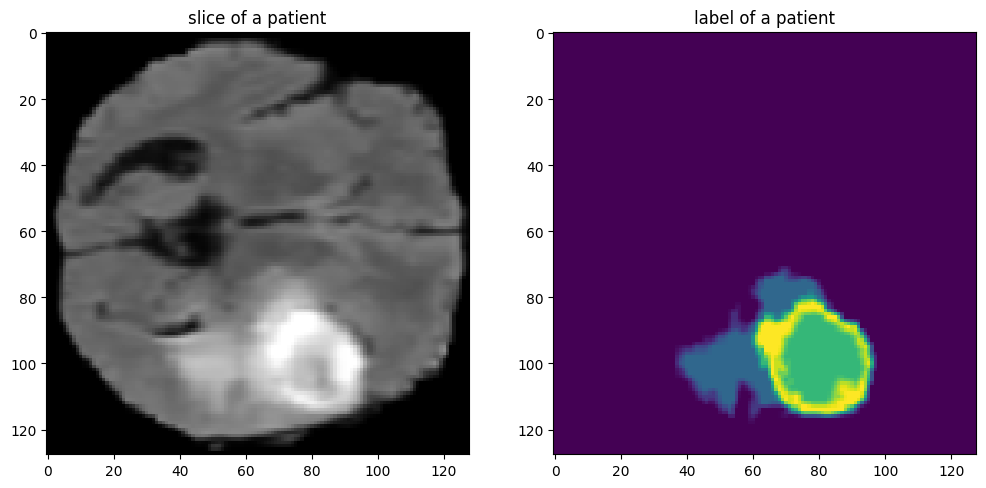

In [11]:
show_figure(patient)

MODEL

In [12]:
from monai.utils import first
import matplotlib.pyplot as plt
import torch
import os
import numpy as np
from monai.losses import DiceLoss
from tqdm import tqdm

def dice_metric(predicted, target):
    '''
    In this function we take `predicted` and `target` (label) to calculate the dice coeficient then we use it 
    to calculate a metric value for the training and the validation.
    '''
    dice_value = DiceLoss(to_onehot_y=True, sigmoid=True, squared_pred=True)
    value = 1 - dice_value(predicted, target).item()
    return value

def calculate_weights(val1, val2):
    '''
    In this function we take the number of the background and the forgroud pixels to return the `weights` 
    for the cross entropy loss values.
    '''
    count = np.array([val1, val2])
    summ = count.sum()
    weights = count/summ
    weights = 1/weights
    summ = weights.sum()
    weights = weights/summ
    return torch.tensor(weights, dtype=torch.float32)

def train(model, data_in, loss, optim, max_epochs, model_dir, test_interval=1 , device=torch.device("cpu")):
    best_metric = -1
    best_metric_epoch = -1
    save_loss_train = []
    save_loss_test = []
    save_metric_train = []
    save_metric_test = []
    train_loader, test_loader = data_in

    for epoch in range(max_epochs):
        print("-" * 10)
        print(f"epoch {epoch + 1}/{max_epochs}")
        model.train()
        train_epoch_loss = 0
        train_step = 0
        epoch_metric_train = 0
        for batch_data in train_loader:
            
            train_step += 1

            volume = batch_data["image"]
            label = batch_data["label"]
            label = label != 0
            volume, label = (volume.to(device), label.to(device))

            optim.zero_grad()
            outputs = model(volume)
            
            train_loss = loss(outputs, label)
            
            train_loss.backward()
            optim.step()

            train_epoch_loss += train_loss.item()
            print(
                f"{train_step}/{len(train_loader) // train_loader.batch_size}, "
                f"Train_loss: {train_loss.item():.4f}")

            train_metric = dice_metric(outputs, label)
            epoch_metric_train += train_metric
            print(f'Train_dice: {train_metric:.4f}')

        print('-'*20)
        
        train_epoch_loss /= train_step
        print(f'Epoch_loss: {train_epoch_loss:.4f}')
        save_loss_train.append(train_epoch_loss)
        np.save(os.path.join(model_dir, 'loss_train.npy'), save_loss_train)
        
        epoch_metric_train /= train_step
        print(f'Epoch_metric: {epoch_metric_train:.4f}')

        save_metric_train.append(epoch_metric_train)
        np.save(os.path.join(model_dir, 'metric_train.npy'), save_metric_train)

        if (epoch + 1) % test_interval == 0:

            model.eval()
            with torch.no_grad():
                test_epoch_loss = 0
                test_metric = 0
                epoch_metric_test = 0
                test_step = 0

                for test_data in test_loader:

                    test_step += 1

                    test_volume = test_data["image"]
                    test_label = test_data["label"]
                    test_label = test_label != 0
                    test_volume, test_label = (test_volume.to(device), test_label.to(device),)
                    
                    test_outputs = model(test_volume)
                    
                    test_loss = loss(test_outputs, test_label)
                    test_epoch_loss += test_loss.item()
                    test_metric = dice_metric(test_outputs, test_label)
                    epoch_metric_test += test_metric
                    
                
                test_epoch_loss /= test_step
                print(f'test_loss_epoch: {test_epoch_loss:.4f}')
                save_loss_test.append(test_epoch_loss)
                np.save(os.path.join(model_dir, 'loss_test.npy'), save_loss_test)

                epoch_metric_test /= test_step
                print(f'test_dice_epoch: {epoch_metric_test:.4f}')
                save_metric_test.append(epoch_metric_test)
                np.save(os.path.join(model_dir, 'metric_test.npy'), save_metric_test)

                if epoch_metric_test > best_metric:
                    best_metric = epoch_metric_test
                    best_metric_epoch = epoch + 1
                    torch.save(model.state_dict(), os.path.join(
                        model_dir, "best_metric_model.pth"))
                
                print(
                    f"current epoch: {epoch + 1} current mean dice: {test_metric:.4f}"
                    f"\nbest mean dice: {best_metric:.4f} "
                    f"at epoch: {best_metric_epoch}"
                )


    print(
        f"train completed, best_metric: {best_metric:.4f} "
        f"at epoch: {best_metric_epoch}")



In [13]:
def calculate_pixels(data):
    val = np.zeros((1, 2))

    for batch in tqdm(data):
        batch_label = batch["label"] != 0
        _, count = np.unique(batch_label, return_counts=True)

        if len(count) == 1:
            count = np.append(count, 0)
        val += count

    print('The last values:', val)
    return val

In [14]:
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.losses import DiceLoss, DiceCELoss

import torch

data_dir = 'C:/Users/Dinesh/Desktop/brain_tumor_segmentation/Task01_BrainTumour/data_train_test'
model_dir = 'C:/Users/Dinesh/Desktop/brain_tumor_segmentation/Task01_BrainTumour/results/results' 
data_in = data_preparation(data_dir)

In [15]:
device = torch.device("cpu")
model = UNet(
    spatial_dims=3,
    in_channels=4,
    out_channels=2,
    channels=(16, 32, 64, 128, 256), 
    strides=(2, 2, 2, 2),
    num_res_units= 2,
    norm=Norm.BATCH,
).to(device)


#loss_function = DiceCELoss(to_onehot_y=True, sigmoid=True, squared_pred=True, ce_weight=calculate_weights(1792651250,2510860).to(device))
loss_function = DiceLoss(to_onehot_y=True, sigmoid=True, squared_pred=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-5, weight_decay=1e-5, amsgrad=True)

if __name__ == '__main__':
    train(model, data_in, loss_function, optimizer,10, model_dir)

----------
epoch 1/10
1/101, Train_loss: 0.5329
Train_dice: 0.4671
2/101, Train_loss: 0.5639
Train_dice: 0.4361
3/101, Train_loss: 0.5152
Train_dice: 0.4848
4/101, Train_loss: 0.5200
Train_dice: 0.4800
5/101, Train_loss: 0.5482
Train_dice: 0.4518
6/101, Train_loss: 0.5023
Train_dice: 0.4977
7/101, Train_loss: 0.5588
Train_dice: 0.4412
8/101, Train_loss: 0.5046
Train_dice: 0.4954
9/101, Train_loss: 0.4849
Train_dice: 0.5151
10/101, Train_loss: 0.5838
Train_dice: 0.4162
11/101, Train_loss: 0.5124
Train_dice: 0.4876
12/101, Train_loss: 0.5842
Train_dice: 0.4158
13/101, Train_loss: 0.5889
Train_dice: 0.4111
14/101, Train_loss: 0.5224
Train_dice: 0.4776
15/101, Train_loss: 0.5072
Train_dice: 0.4928
16/101, Train_loss: 0.5513
Train_dice: 0.4487
17/101, Train_loss: 0.5338
Train_dice: 0.4662
18/101, Train_loss: 0.5252
Train_dice: 0.4748
19/101, Train_loss: 0.5133
Train_dice: 0.4867
20/101, Train_loss: 0.4822
Train_dice: 0.5178
21/101, Train_loss: 0.5600
Train_dice: 0.4400
22/101, Train_loss: 0

In [16]:
from monai.utils import first, set_determinism
from monai.transforms import(
    Compose,
    EnsureChannelFirstD,
    LoadImaged,
    Resized,
    ToTensord,
    Spacingd,
    Orientationd,
    ScaleIntensityRanged,
    CropForegroundd,
    Activations,
)

from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.data import CacheDataset, DataLoader, Dataset

import torch
import matplotlib.pyplot as plt

import os
from glob import glob
import numpy as np

from monai.inferers import sliding_window_inference

In [17]:
data_dir = 'C:/Users/Dinesh/Desktop/brain_tumor_segmentation/Task01_BrainTumour/data_train_test'
model_dir = 'C:/Users/Dinesh/Desktop/brain_tumor_segmentation/Task01_BrainTumour/results/results' 

In [18]:
train_loss = np.load(os.path.join(model_dir, 'loss_train.npy'))
train_metric = np.load(os.path.join(model_dir, 'metric_train.npy'))
test_loss = np.load(os.path.join(model_dir, 'loss_test.npy'))
test_metric = np.load(os.path.join(model_dir, 'metric_test.npy'))

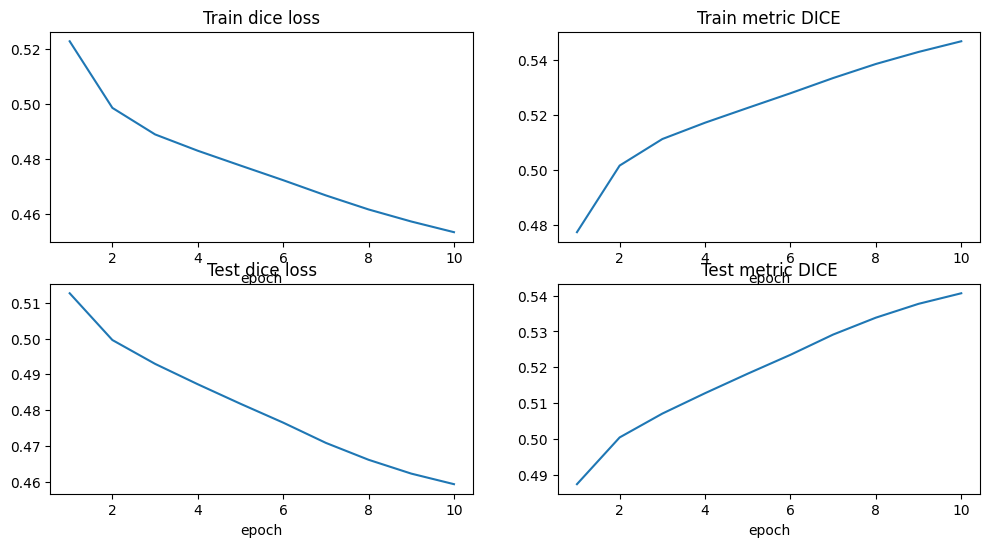

In [19]:
plt.figure("Results 25 june", (12, 6))
plt.subplot(2, 2, 1)
plt.title("Train dice loss")
x = [i + 1 for i in range(len(train_loss))]
y = train_loss
plt.xlabel("epoch")
plt.plot(x, y)

plt.subplot(2, 2, 2)
plt.title("Train metric DICE")
x = [i + 1 for i in range(len(train_metric))]
y = train_metric
plt.xlabel("epoch")
plt.plot(x, y)

plt.subplot(2, 2, 3)
plt.title("Test dice loss")
x = [i + 1 for i in range(len(test_loss))]
y = test_loss
plt.xlabel("epoch")
plt.plot(x, y)

plt.subplot(2, 2, 4)
plt.title("Test metric DICE")
x = [i + 1 for i in range(len(test_metric))]
y = test_metric
plt.xlabel("epoch")
plt.plot(x, y)

plt.show()

In [20]:
path_train_volumes = sorted(glob(os.path.join(in_dir, "train_data", "*.nii.gz")))
path_train_segmentation = sorted(glob(os.path.join(in_dir, "Train_labels", "*.nii.gz")))

path_test_volumes = sorted(glob(os.path.join(in_dir, "val_data", "*.nii.gz")))
path_test_segmentation = sorted(glob(os.path.join(in_dir, "val_labels", "*.nii.gz")))

train_files = [{"image": image_name, "label": label_name} for image_name, label_name in zip(path_train_volumes, path_train_segmentation)]
test_files = [{"image": image_name, "label": label_name} for image_name, label_name in zip(path_test_volumes, path_test_segmentation)]
#test_files = test_files[0:9]

In [21]:
test_transforms = Compose(
        [
            LoadImaged(keys=["image", "label"]),
            EnsureChannelFirstD(keys=["image","label"]),
            Spacingd(keys=["image", "label"], pixdim=(1.5,1.5,2)),
            ScaleIntensityRanged(keys='image', a_min=0, a_max=1400, b_min=0.0, b_max=1.0, clip= True),
            CropForegroundd(keys=['image','label'], source_key = 'image'),
            Resized(keys=['image','label'], spatial_size = [128,128,64]),
            ToTensord(keys =["image", "label"])
    ]
)

In [22]:
test_ds = Dataset(data=test_files, transform=test_transforms)
test_loader = DataLoader(test_ds, batch_size=1)

In [23]:
device = torch.device("cpu")
model = UNet(
    spatial_dims=3,
    in_channels=4,
    out_channels=2,
    channels=(16, 32, 64, 128, 256), 
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)

In [24]:
model.load_state_dict(torch.load(
    os.path.join(model_dir, "best_metric_model.pth")))
model.eval()

UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv3d(4, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
      )
      (residual): Conv3d(4, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Sequential(


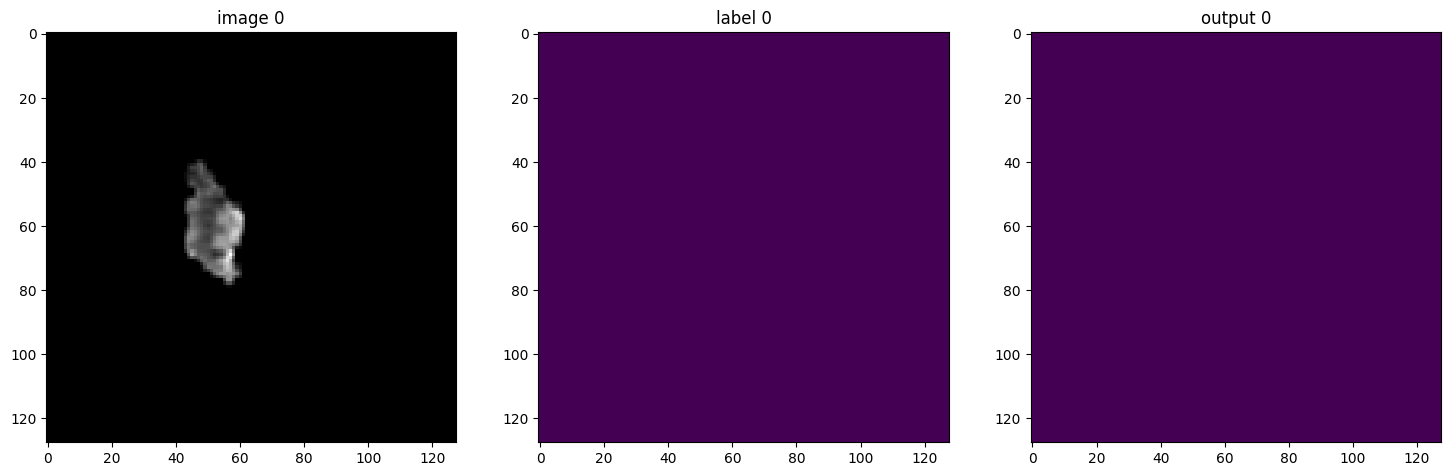

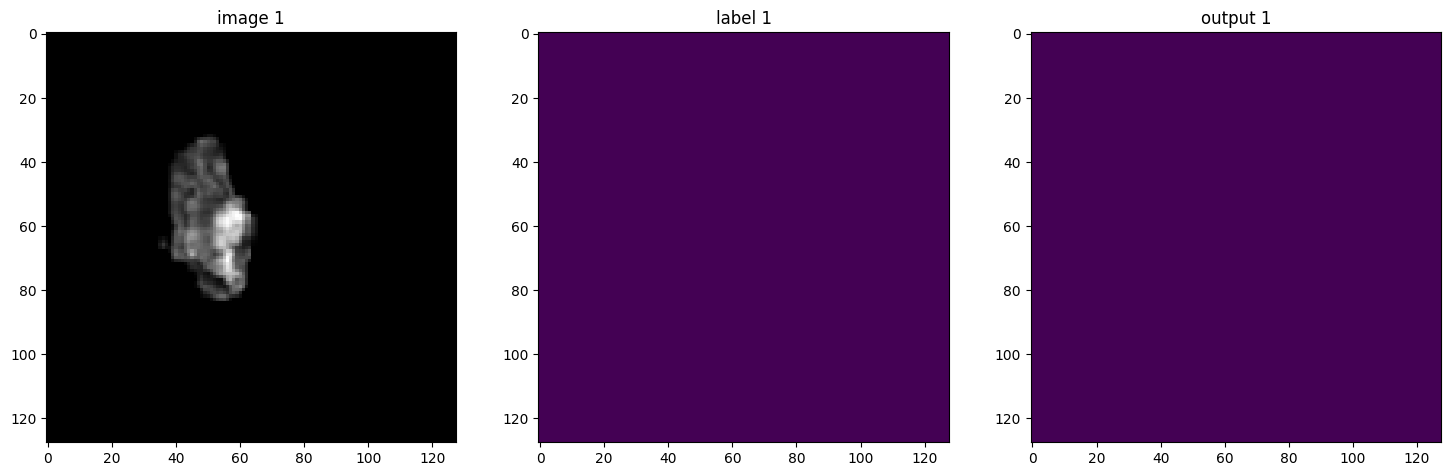

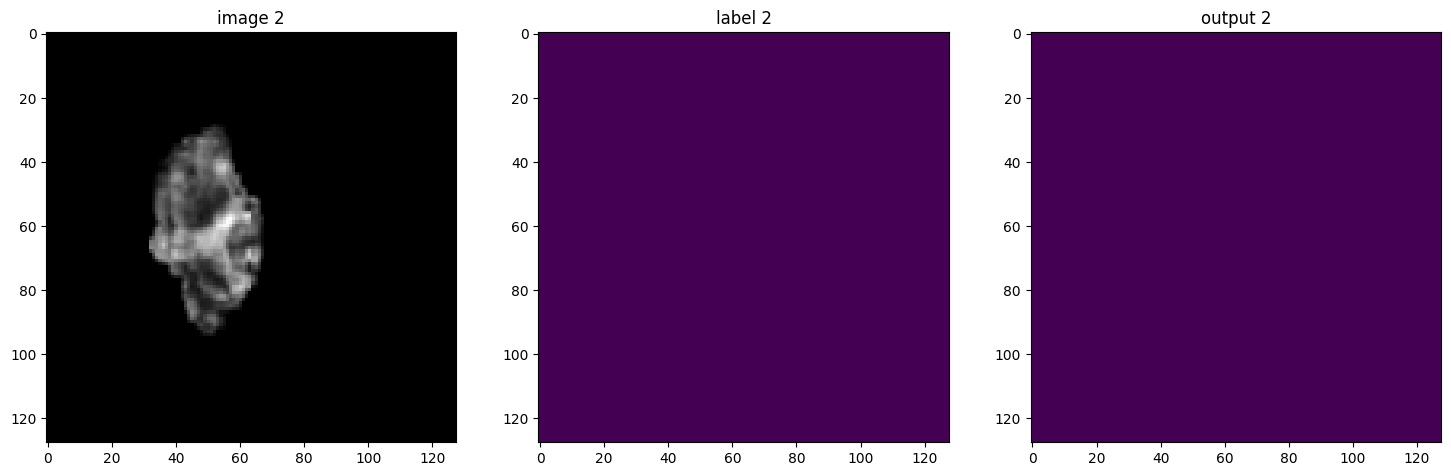

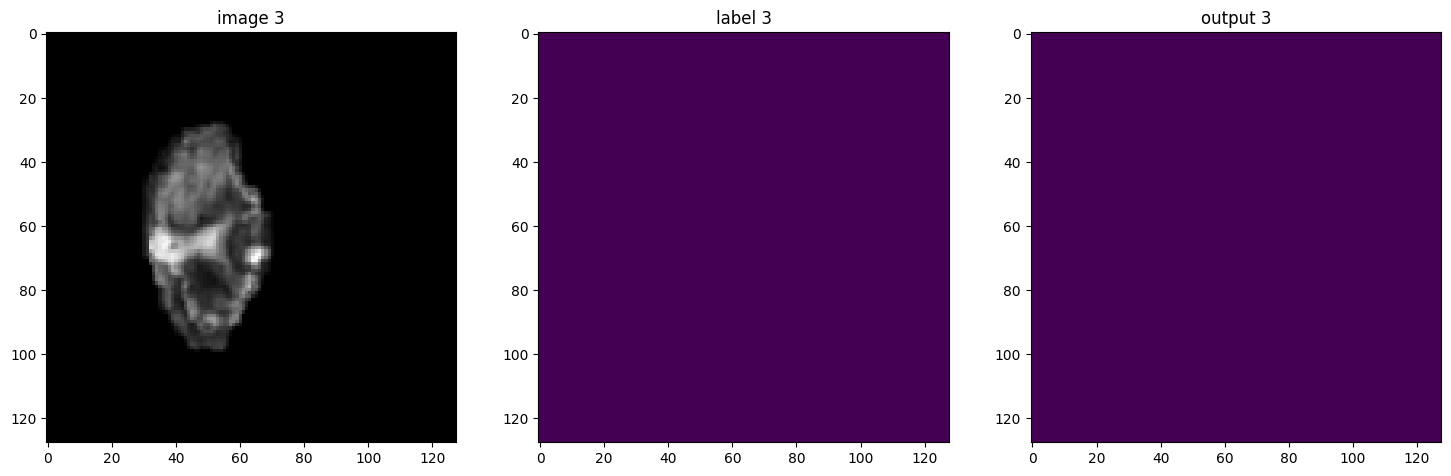

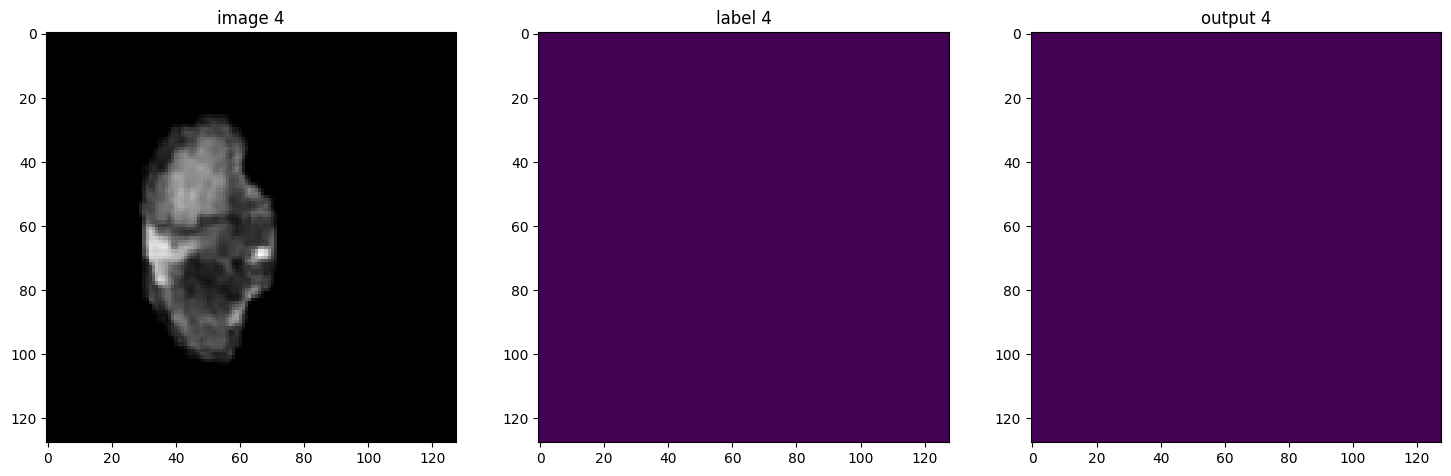

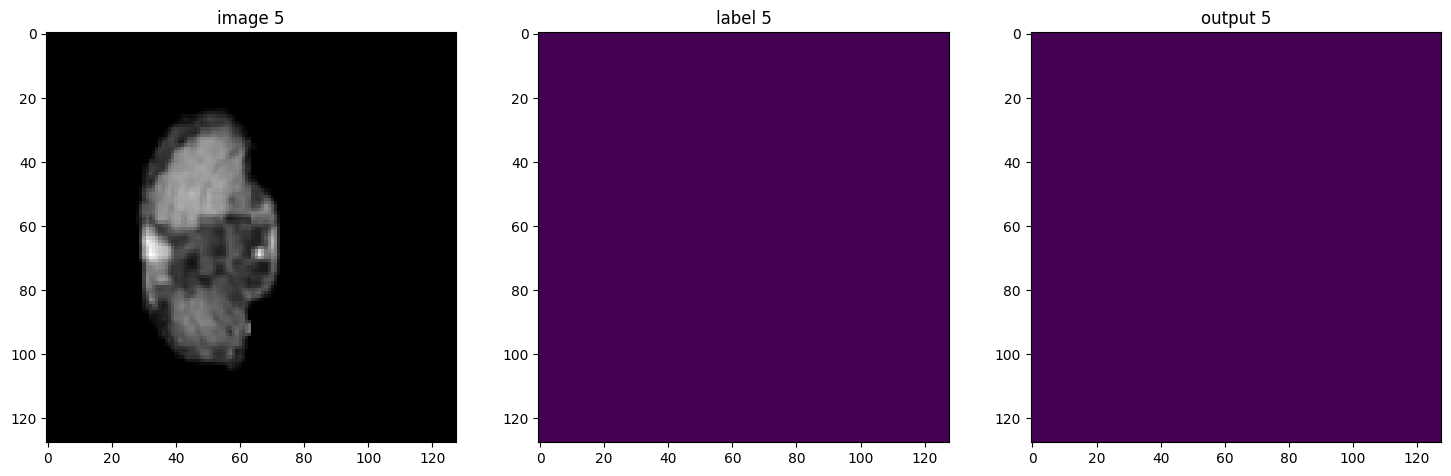

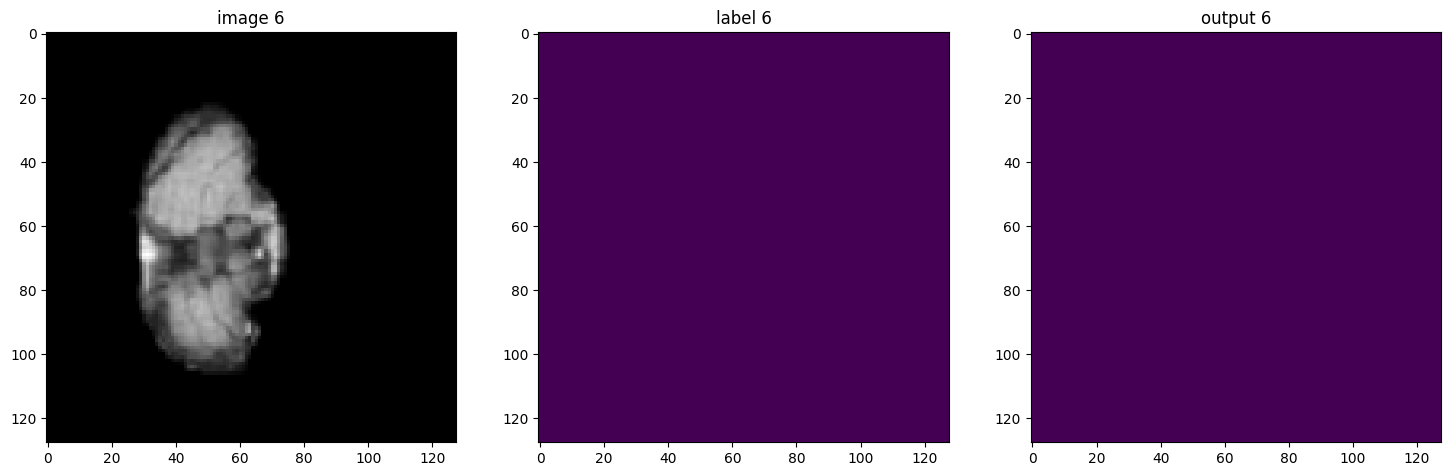

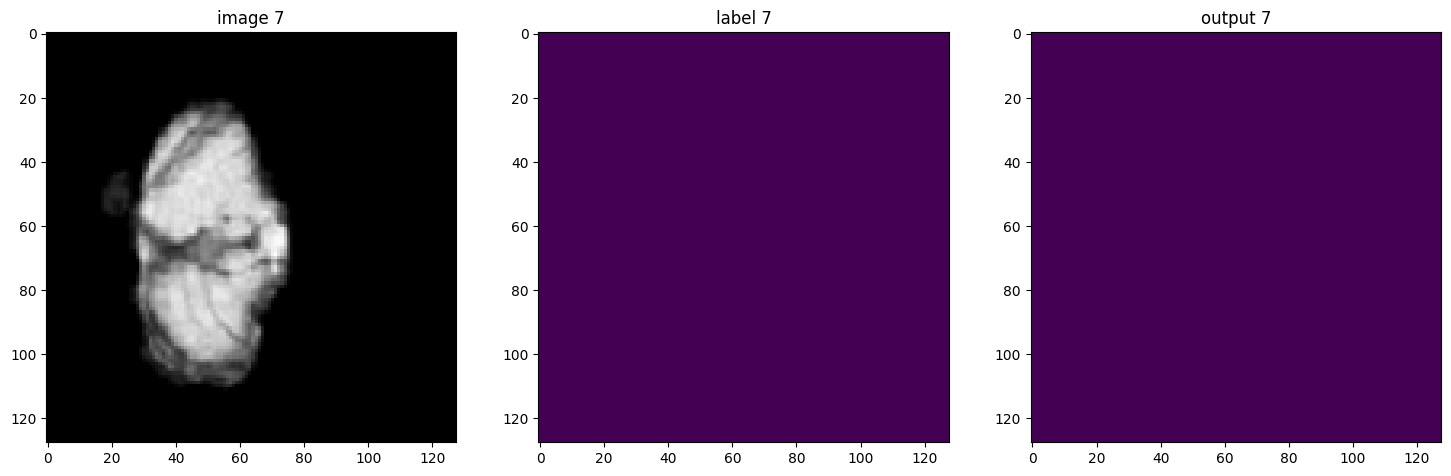

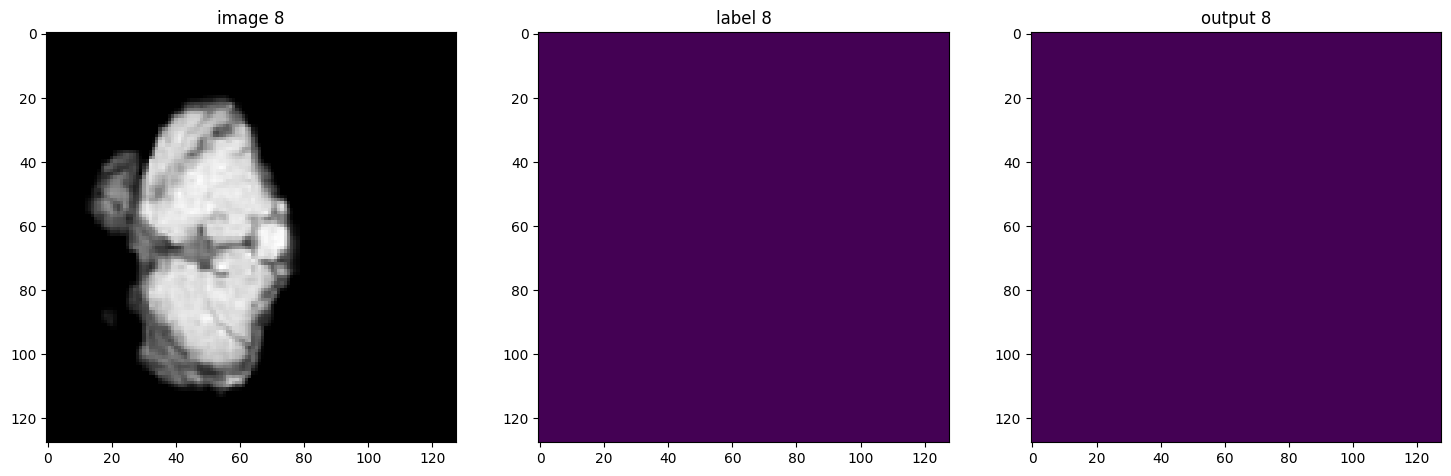

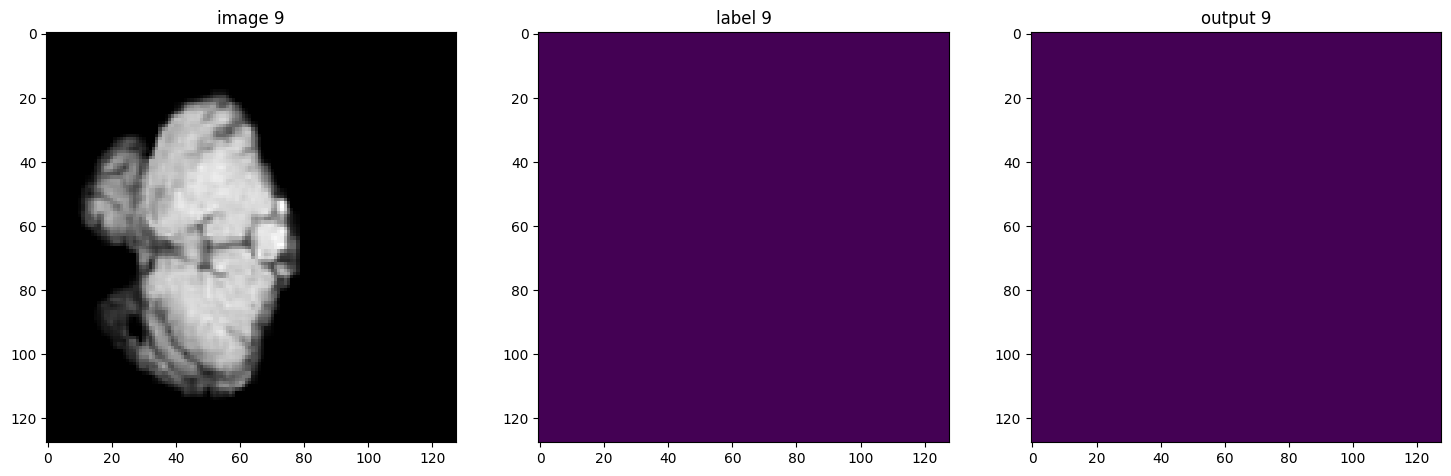

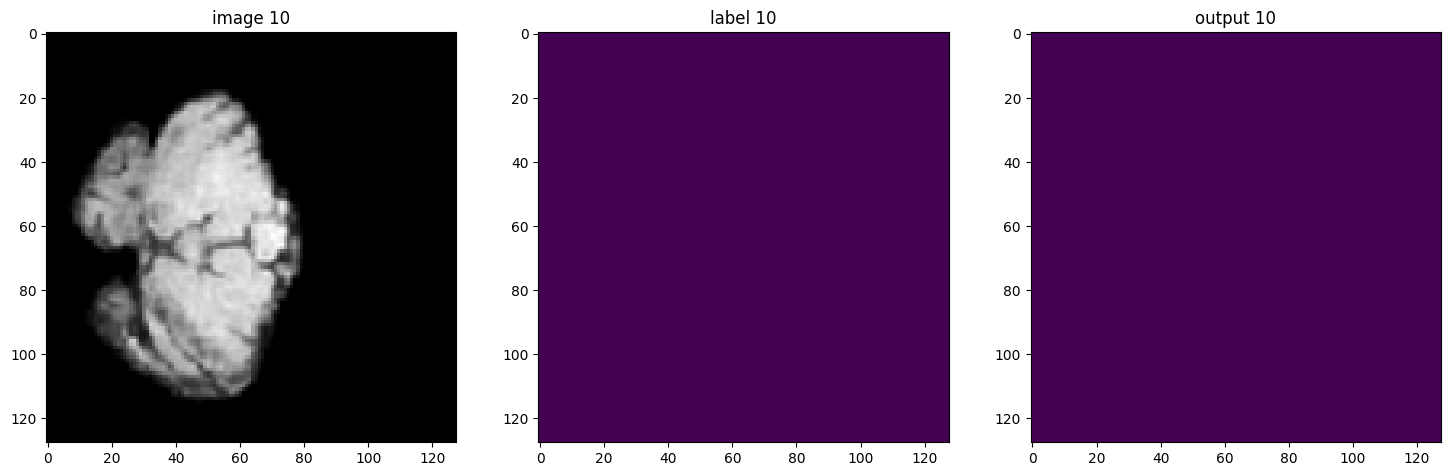

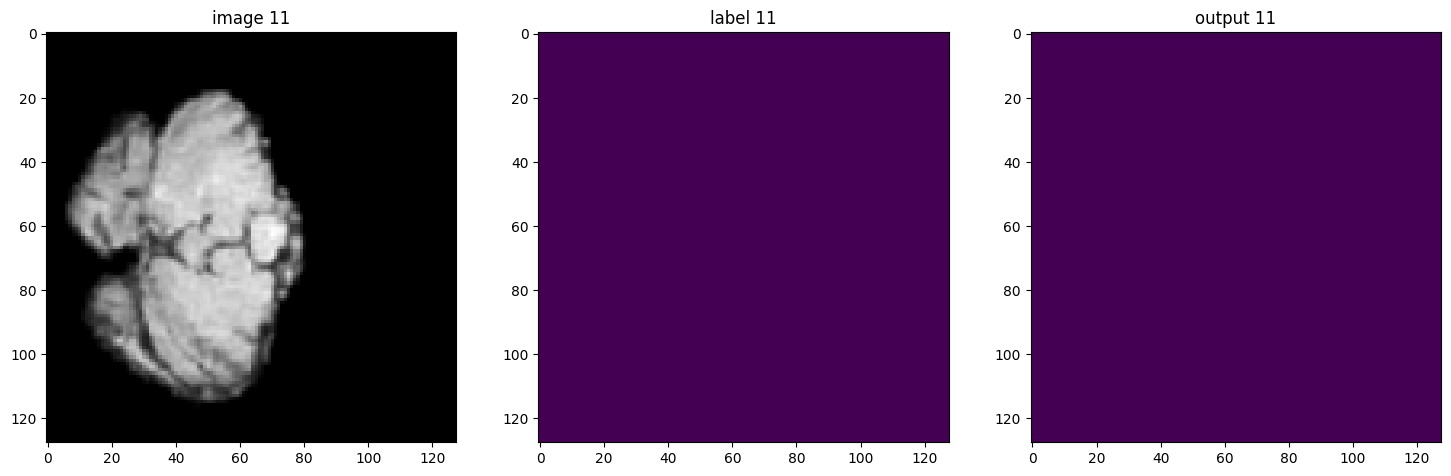

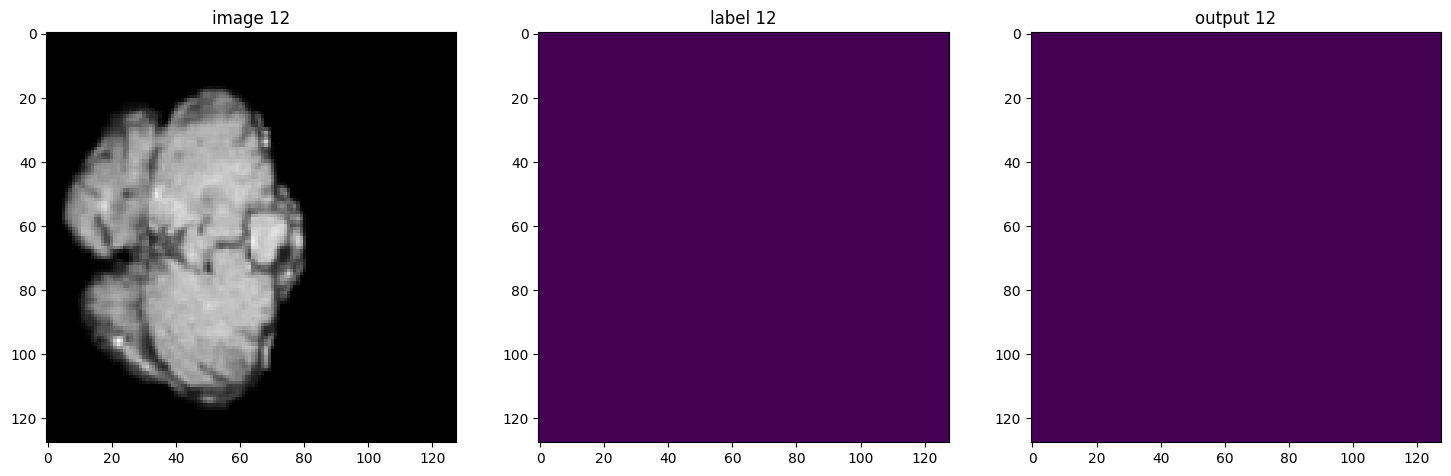

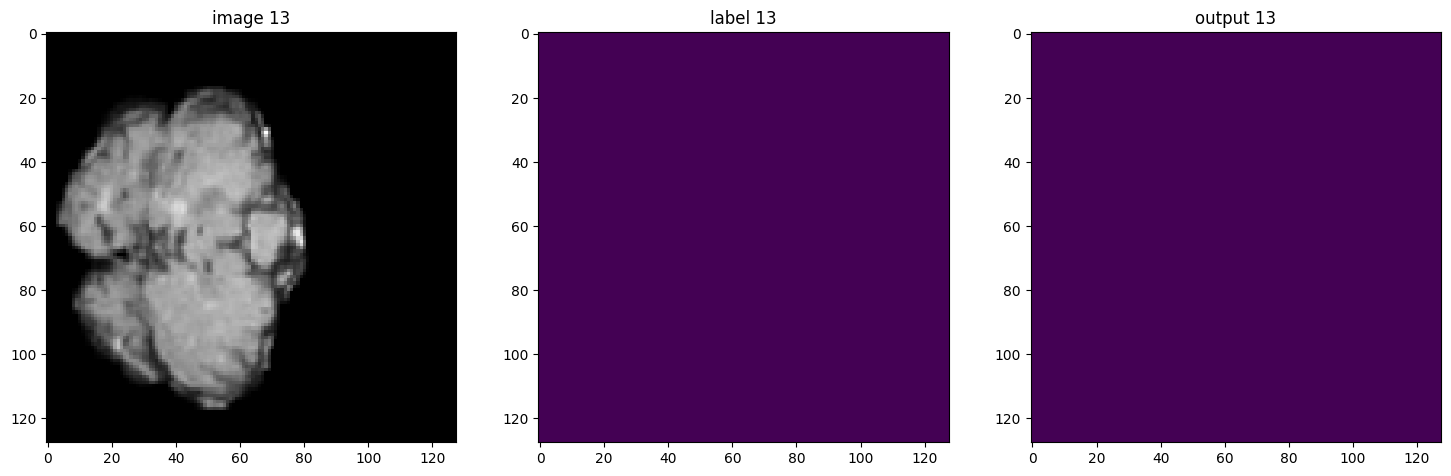

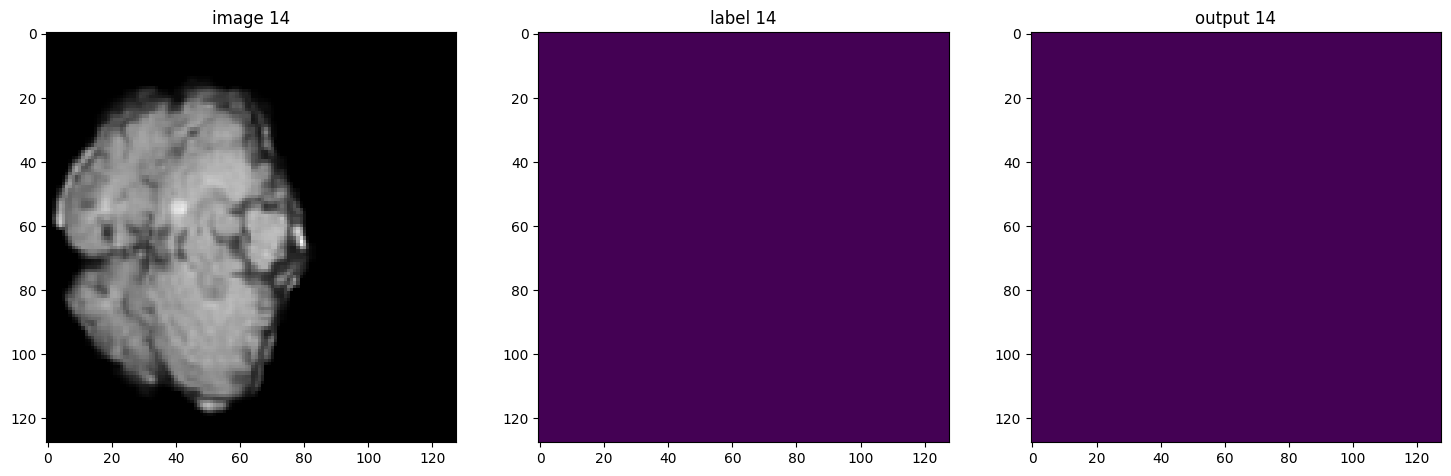

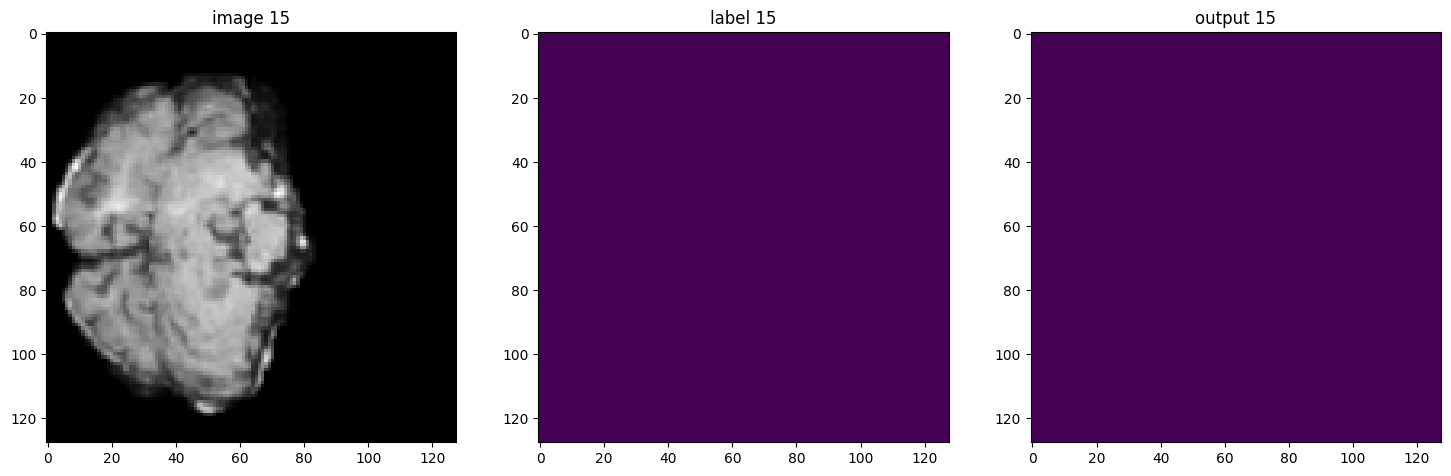

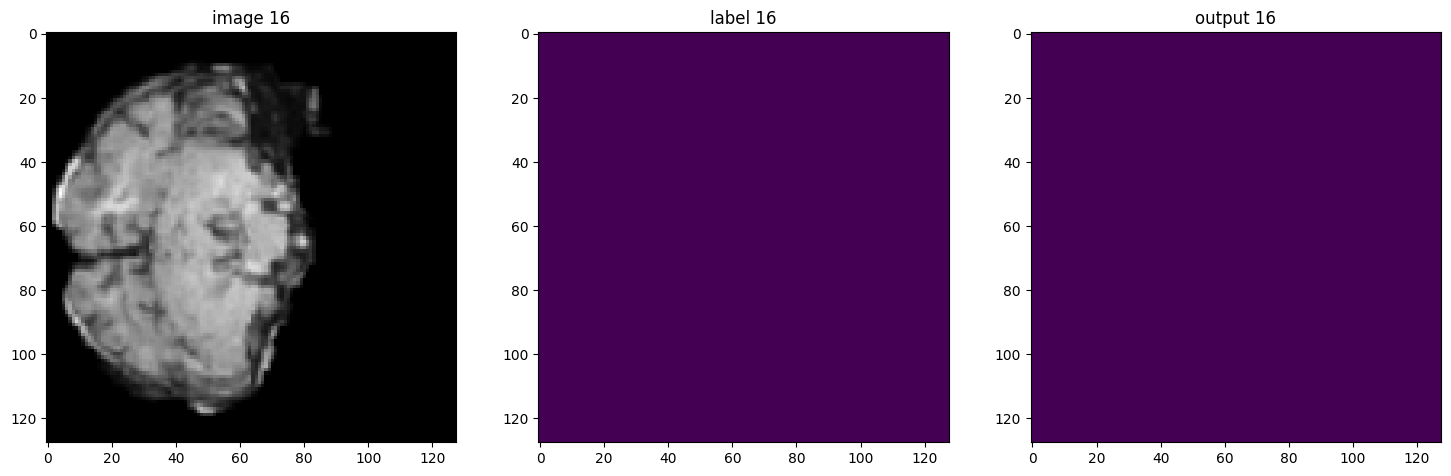

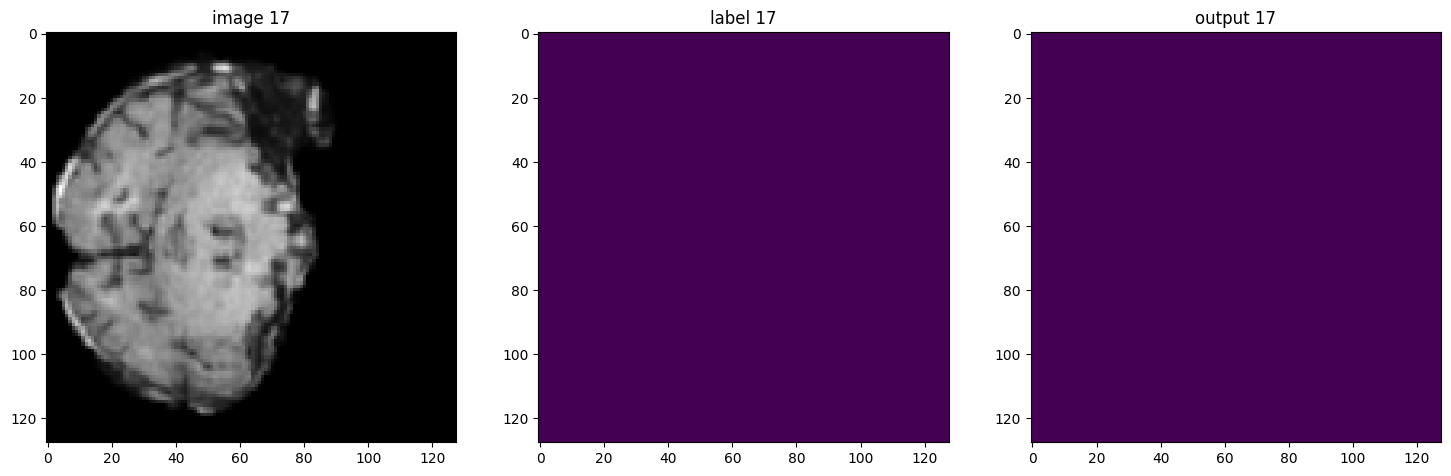

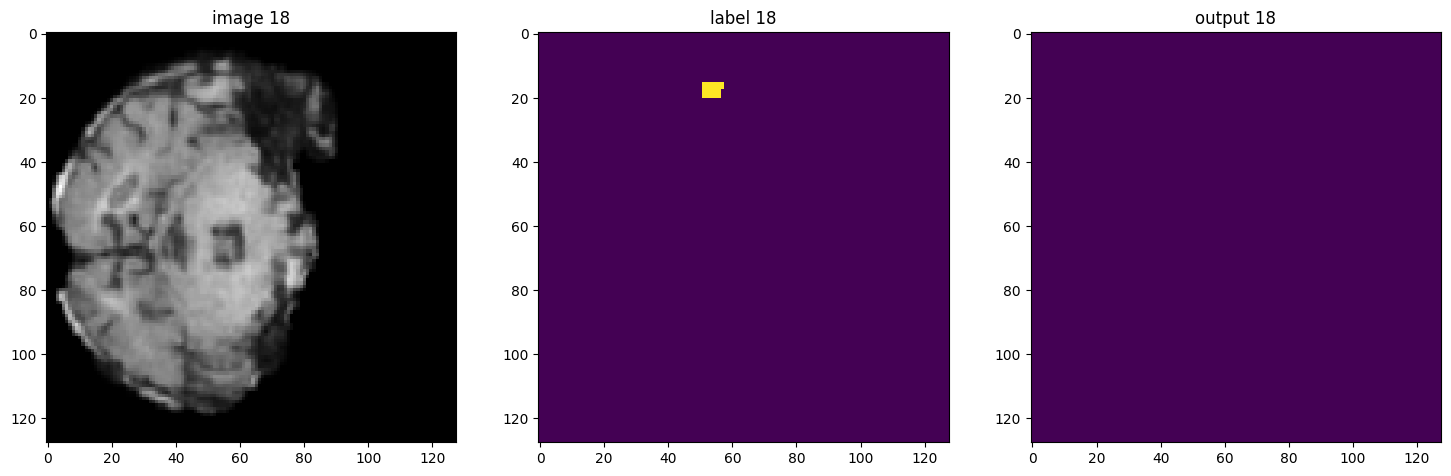

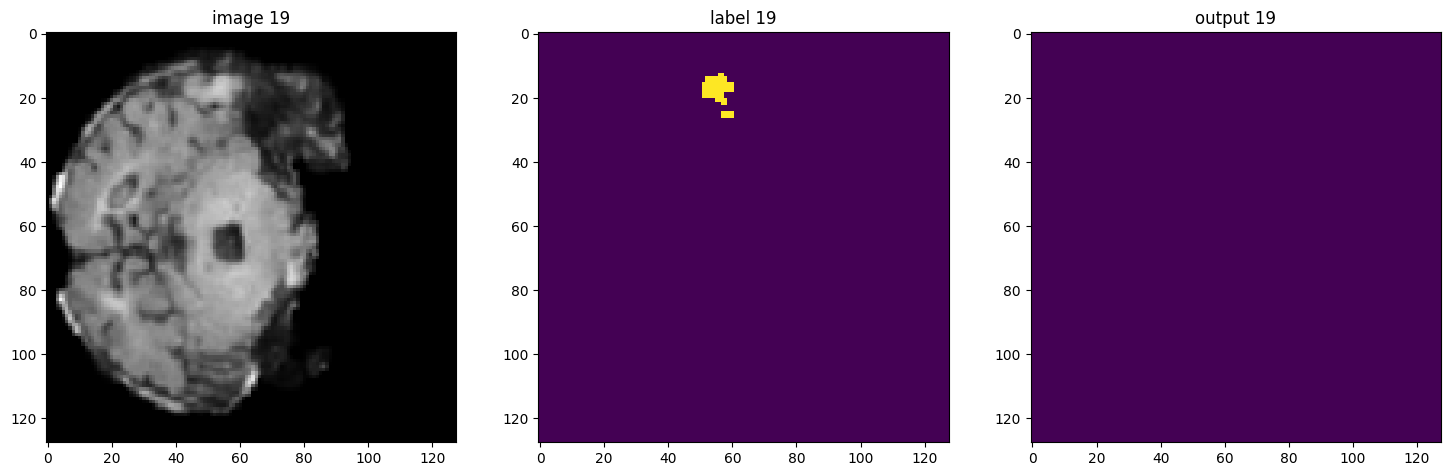

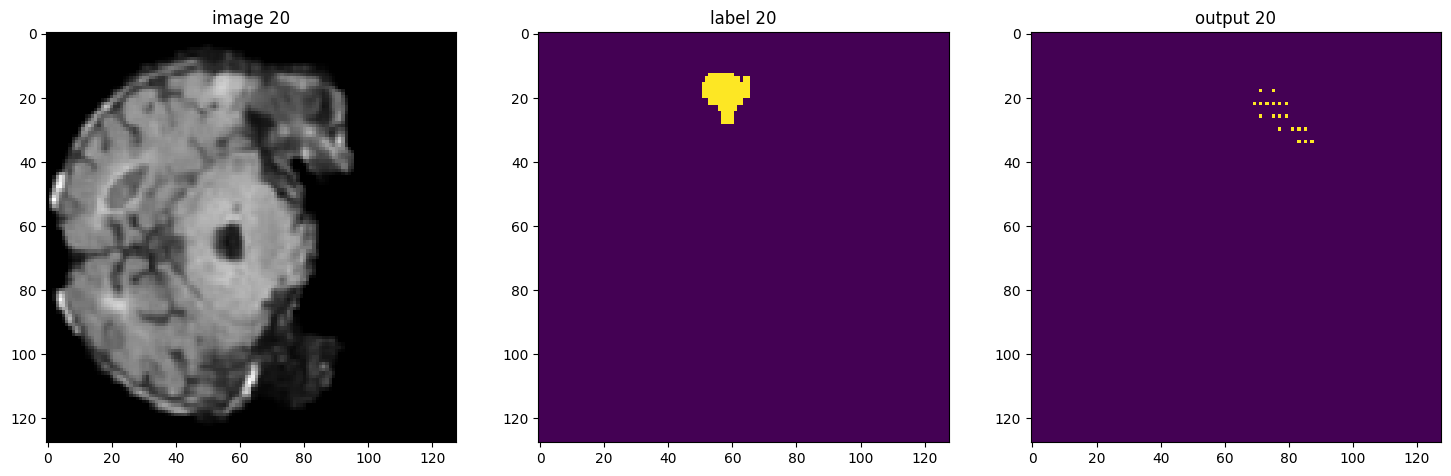

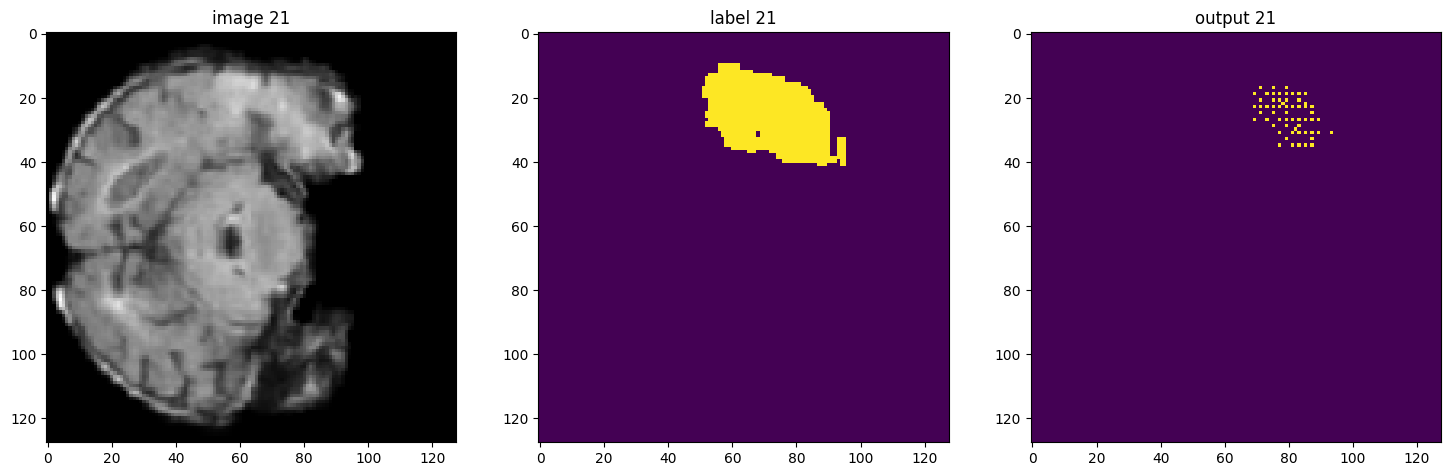

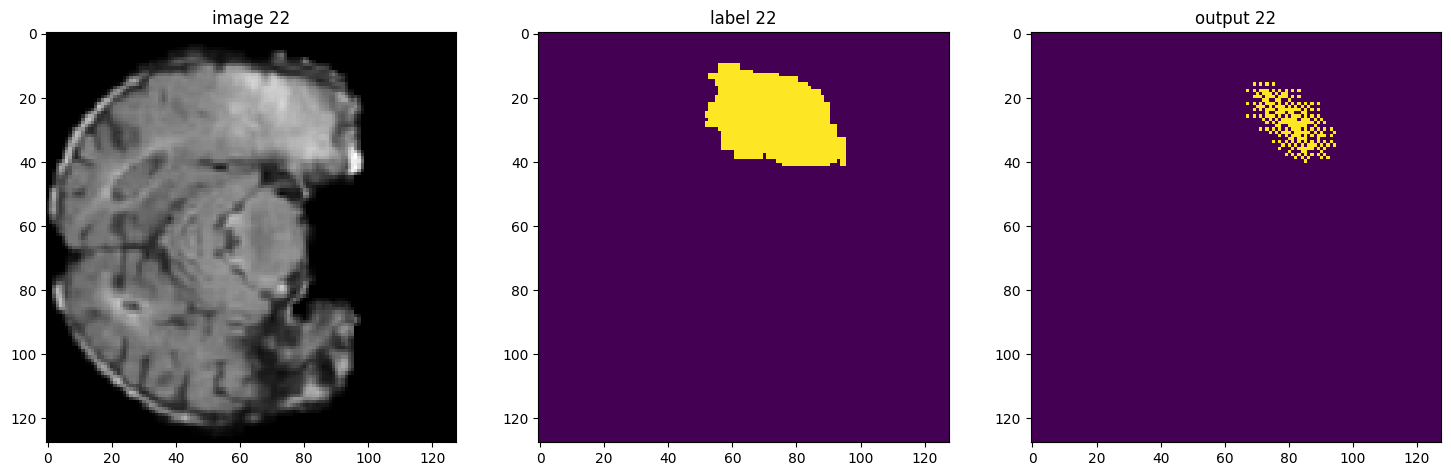

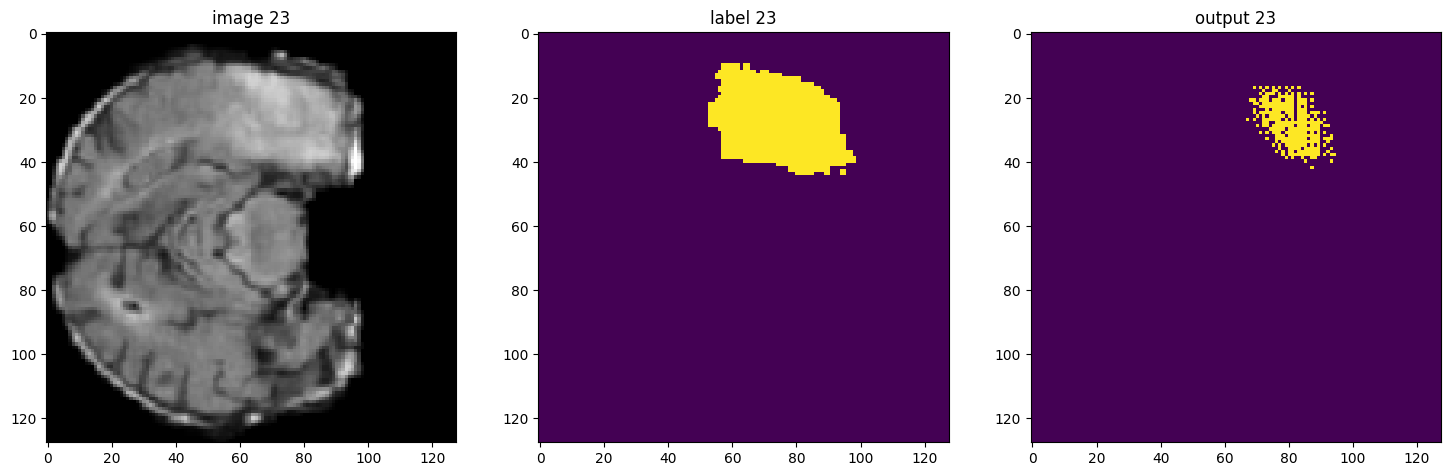

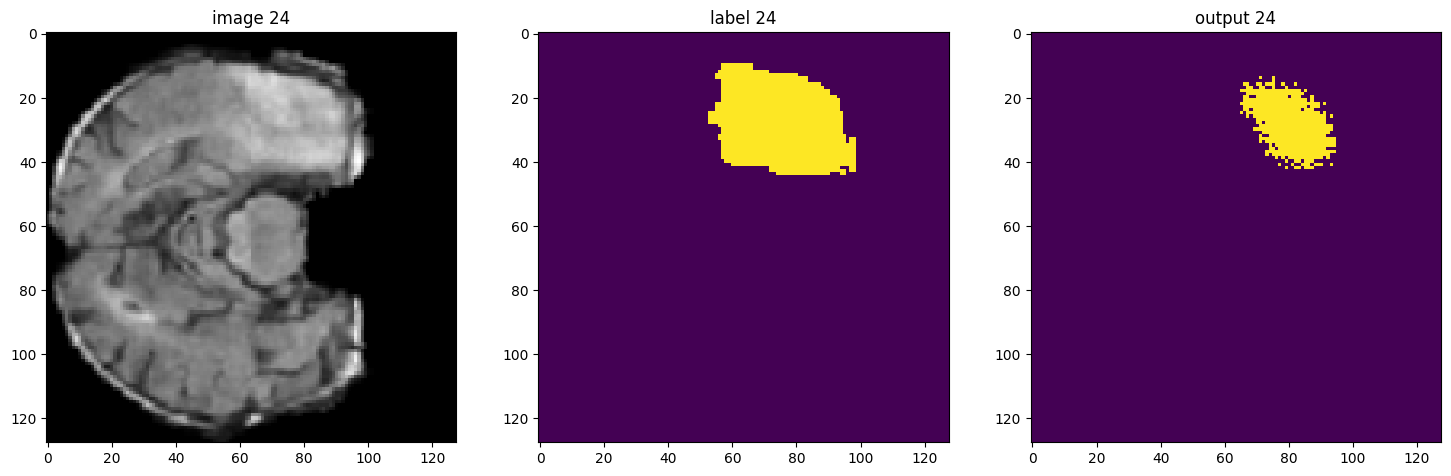

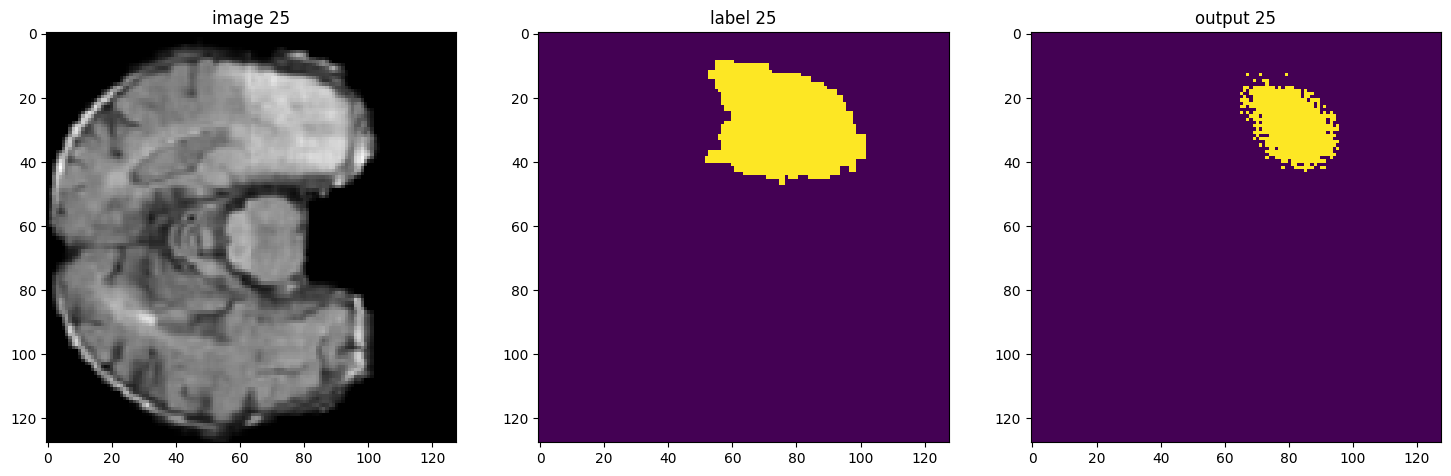

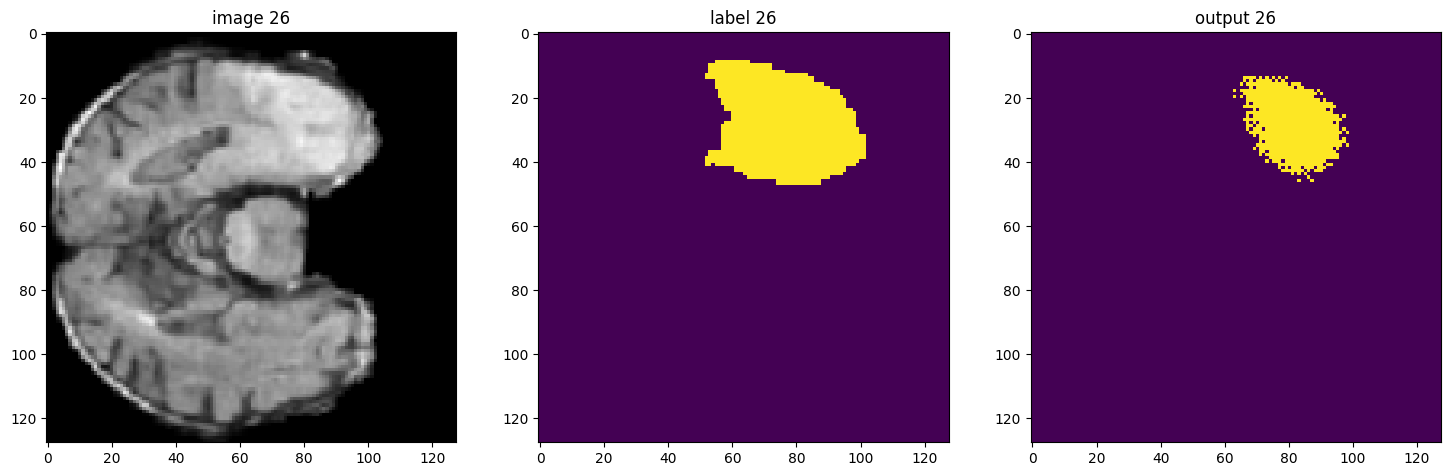

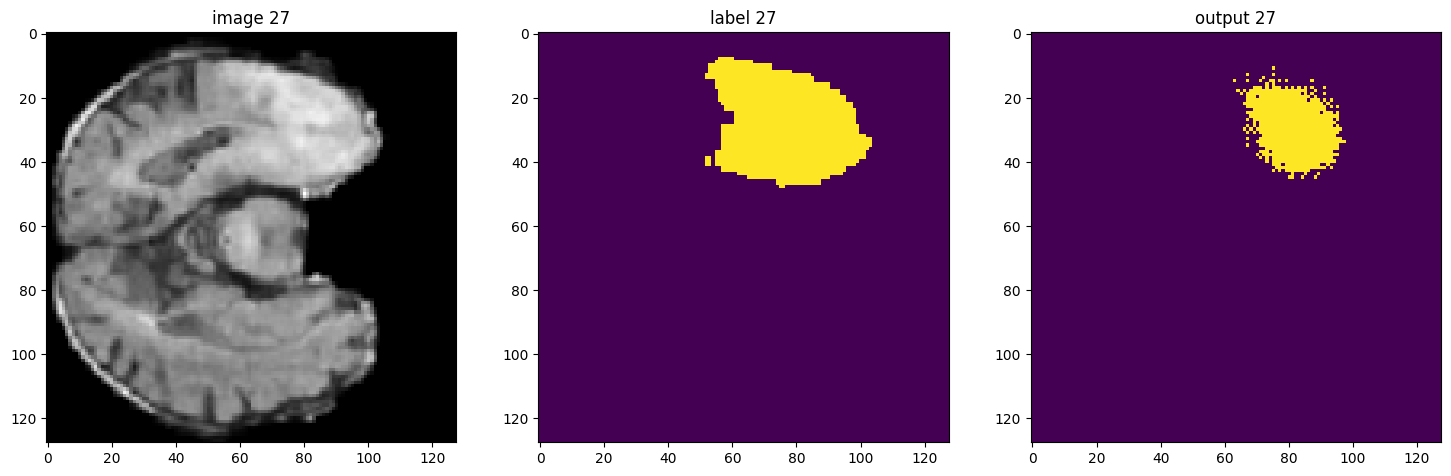

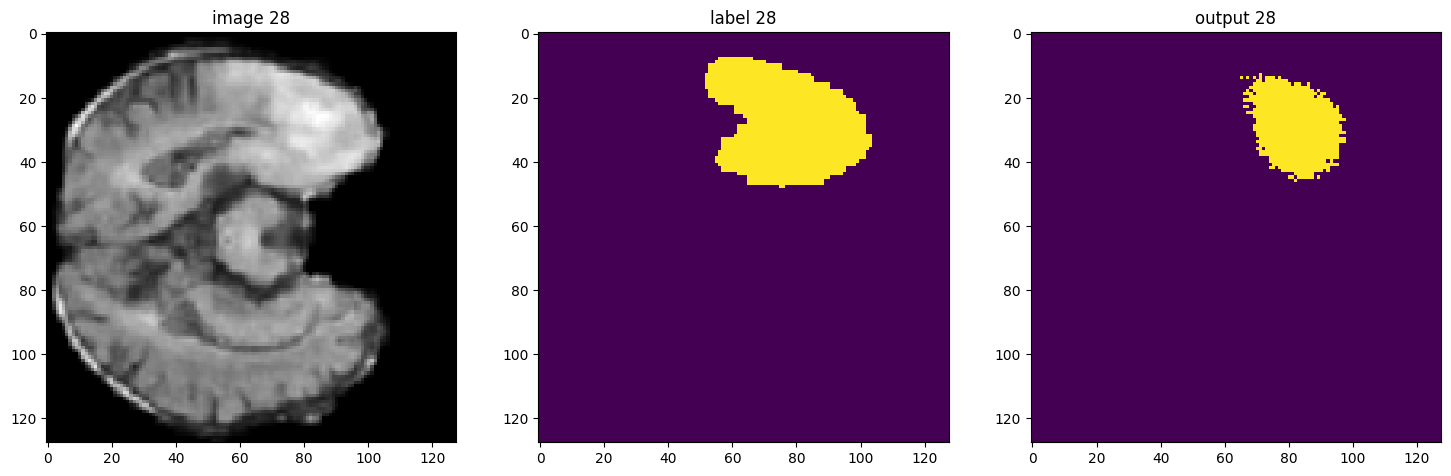

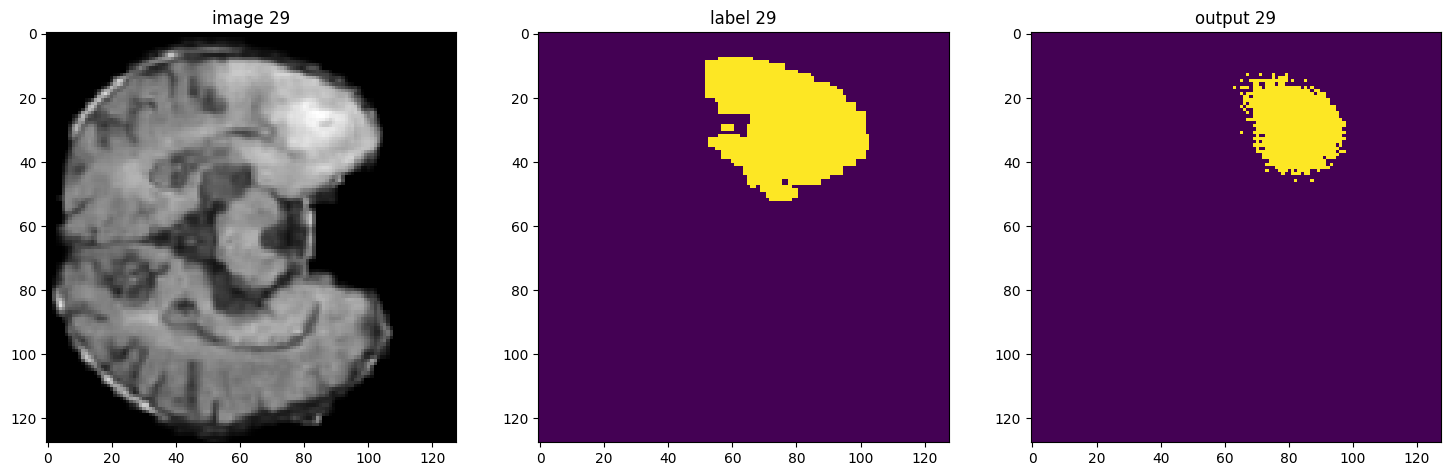

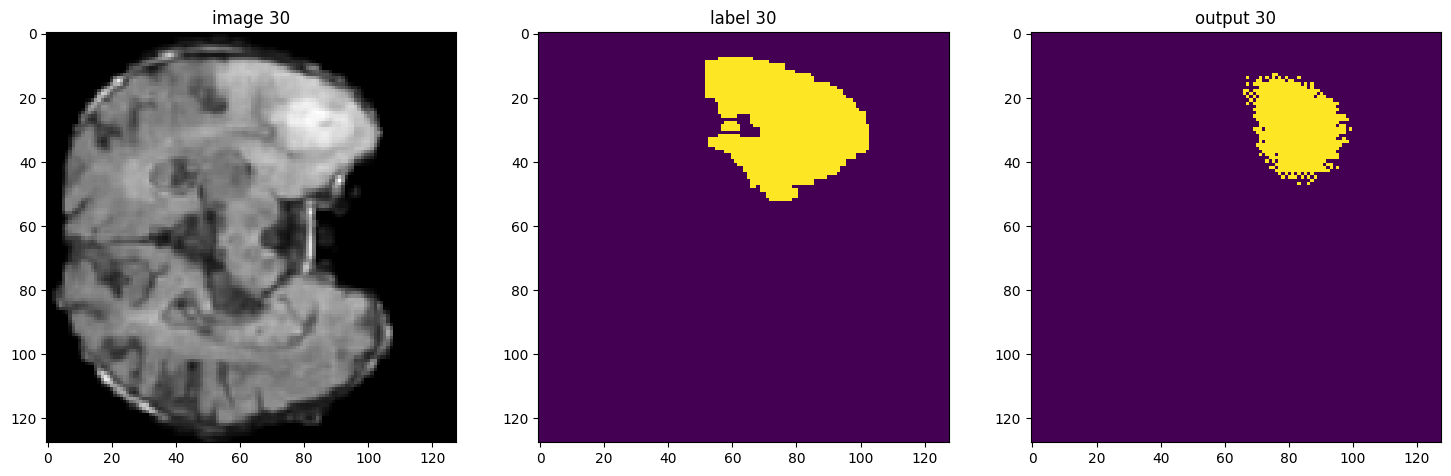

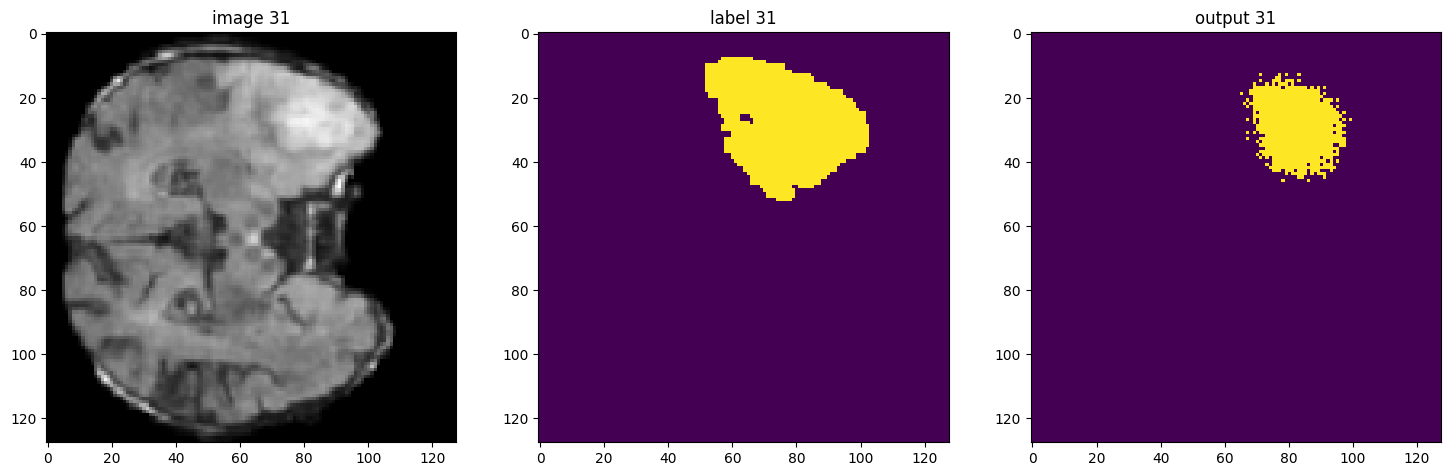

In [25]:
sw_batch_size = 4
roi_size = (128, 128, 64)
with torch.no_grad():
    test_patient = first(test_loader)
    t_volume = test_patient['image']
    #t_segmentation = test_patient['seg']
    
    test_outputs = sliding_window_inference(t_volume.to(device), roi_size, sw_batch_size, model)
    sigmoid_activation = Activations(sigmoid=True)
    test_outputs = sigmoid_activation(test_outputs)
    test_outputs = test_outputs > 0.90
        
    for i in range(32):
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(test_patient["image"][0, 0, :, :, i], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(test_patient["label"][0, 0, :, :, i] != 0)
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(test_outputs.detach().cpu()[0, 1, :, :, i])
        plt.show()

for choosing a random patient

In [26]:
def select_patient(image_num):

    # Create dataset
    test_ds = Dataset(data=test_files, transform=test_transforms)

    # Access the second image
    second_image = test_ds[image_num-1]

    # If you want to create a DataLoader for this single image
    test_loader = DataLoader([second_image], batch_size=1)

    # Retrieve the image using the DataLoader
    test_patient = first(test_loader)

    return test_patient


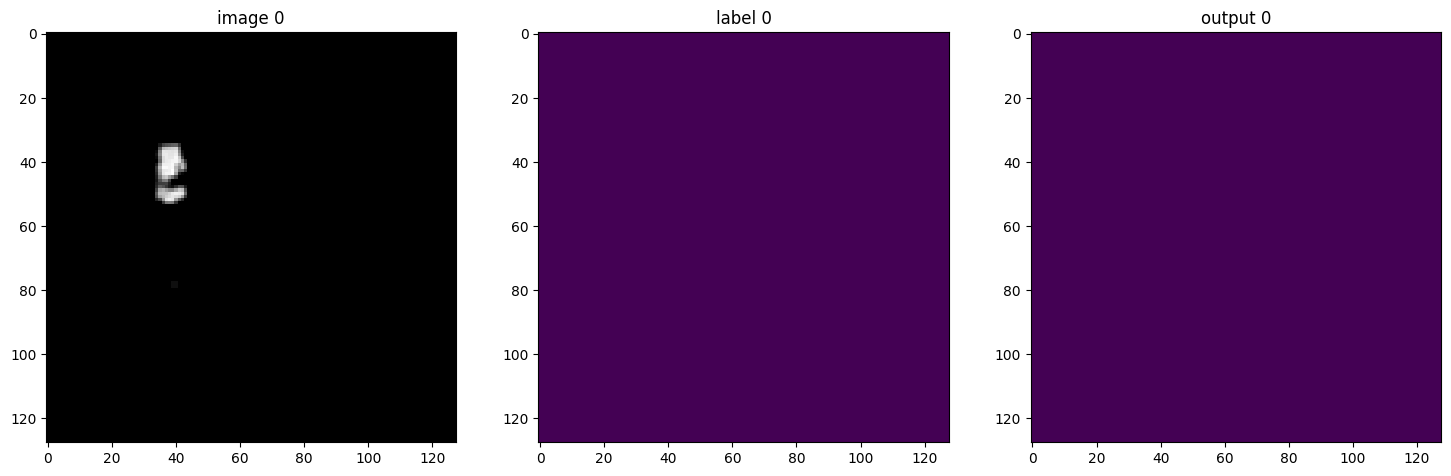

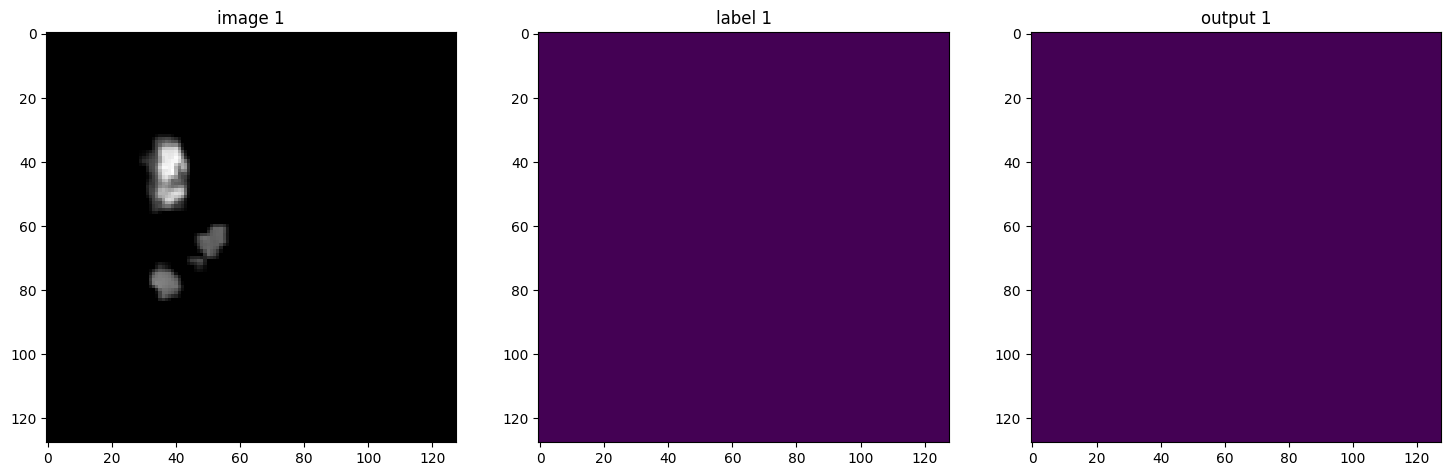

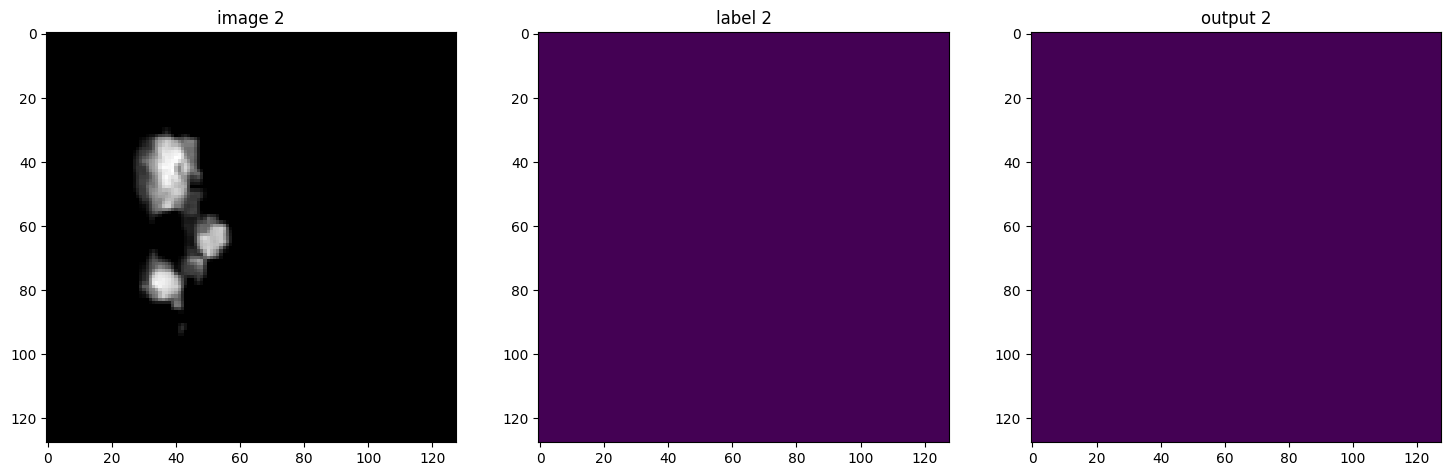

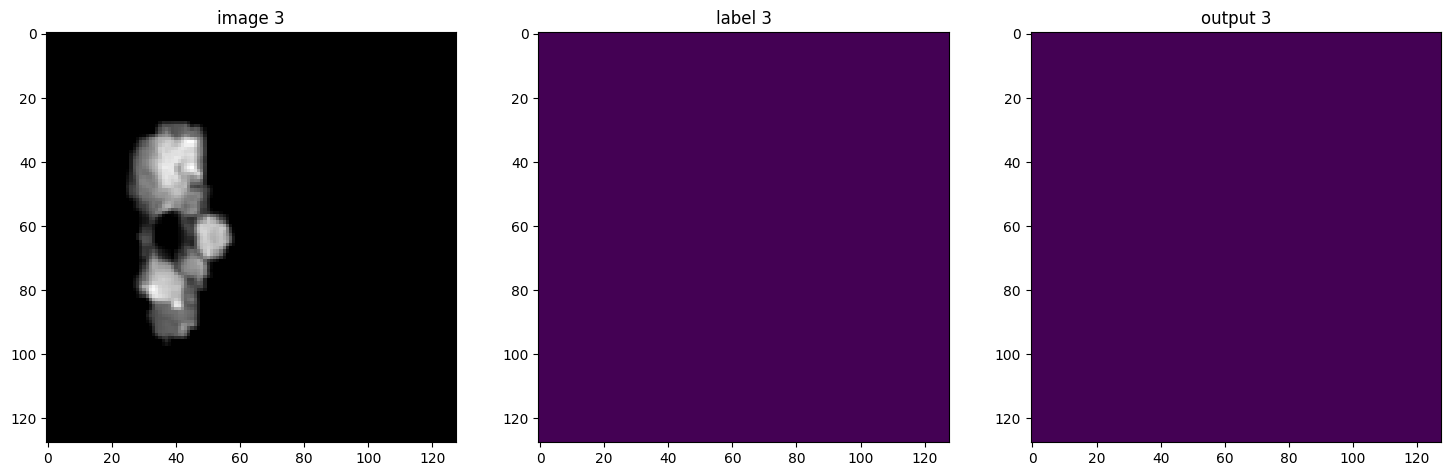

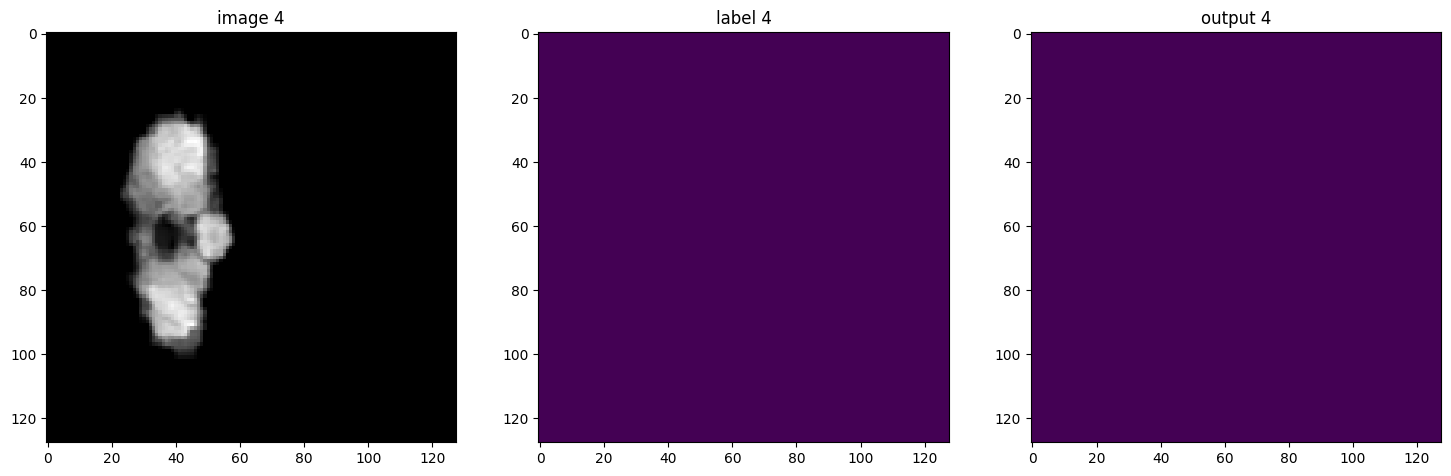

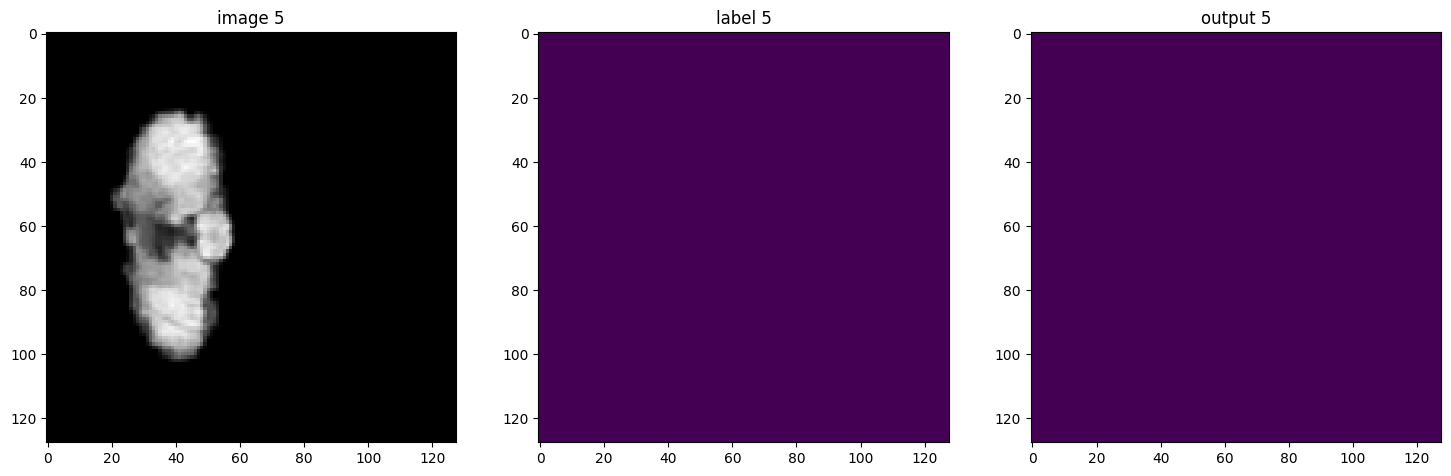

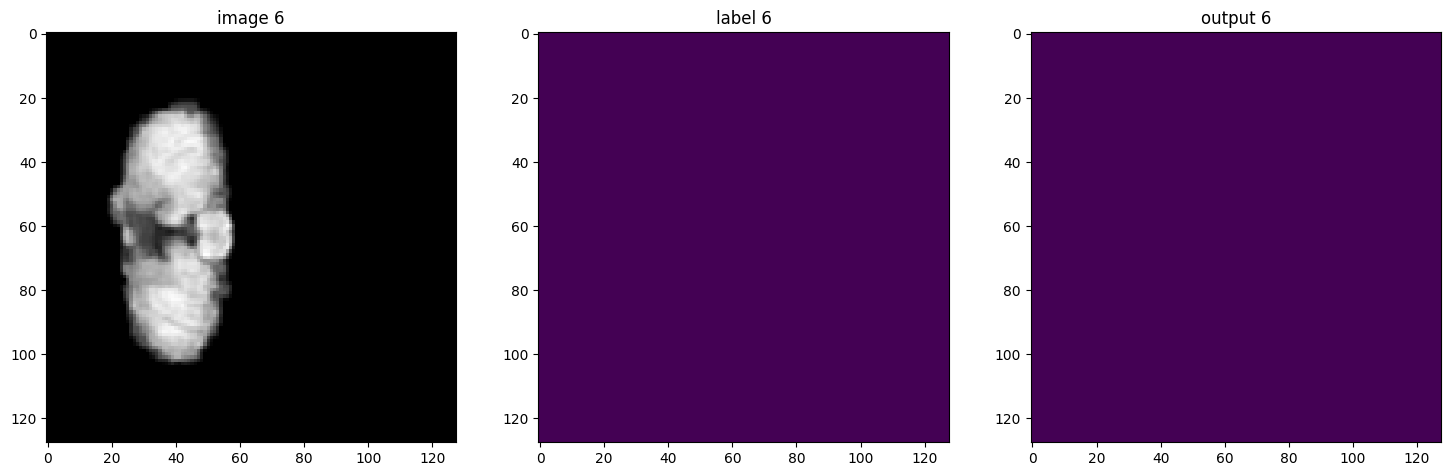

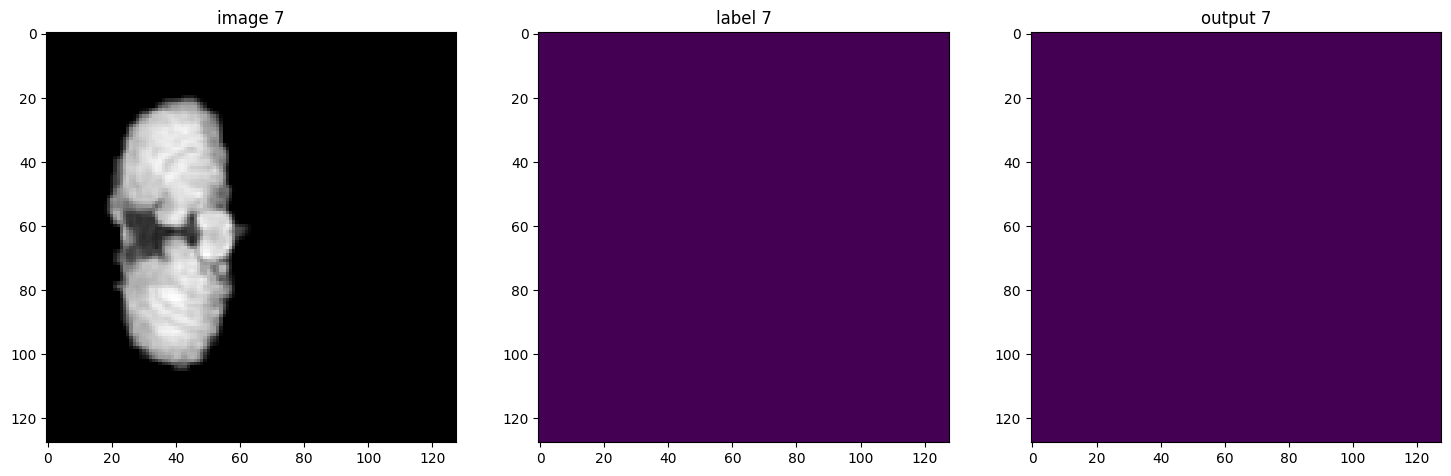

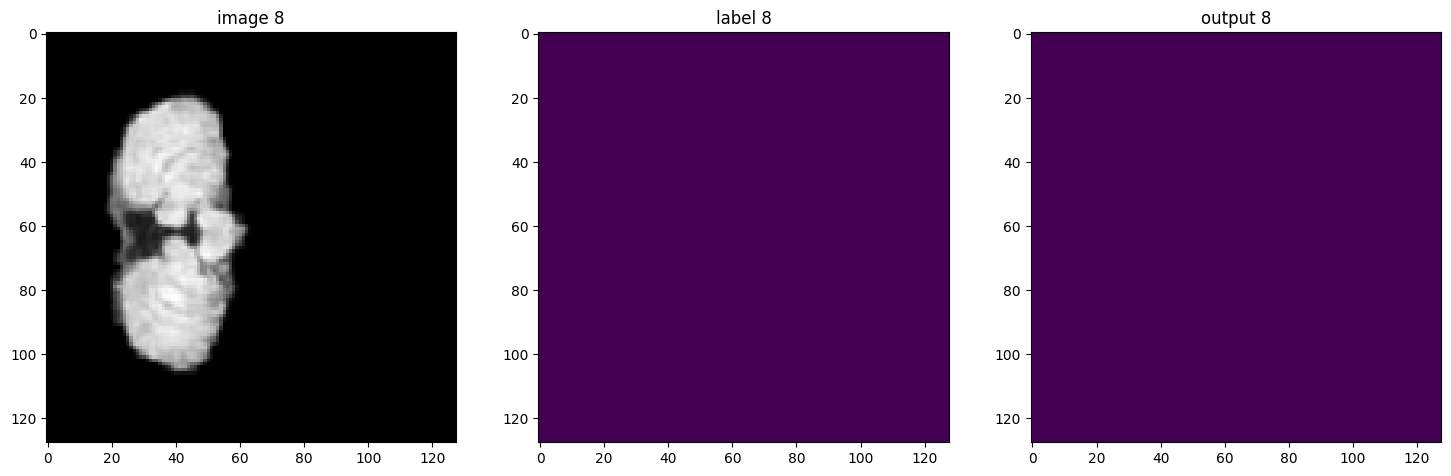

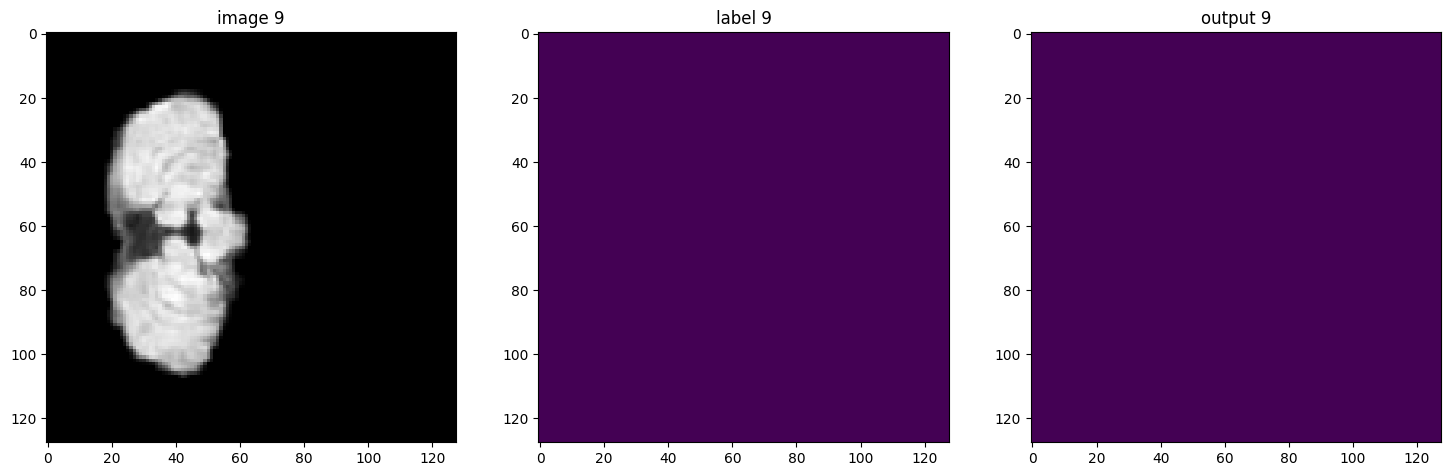

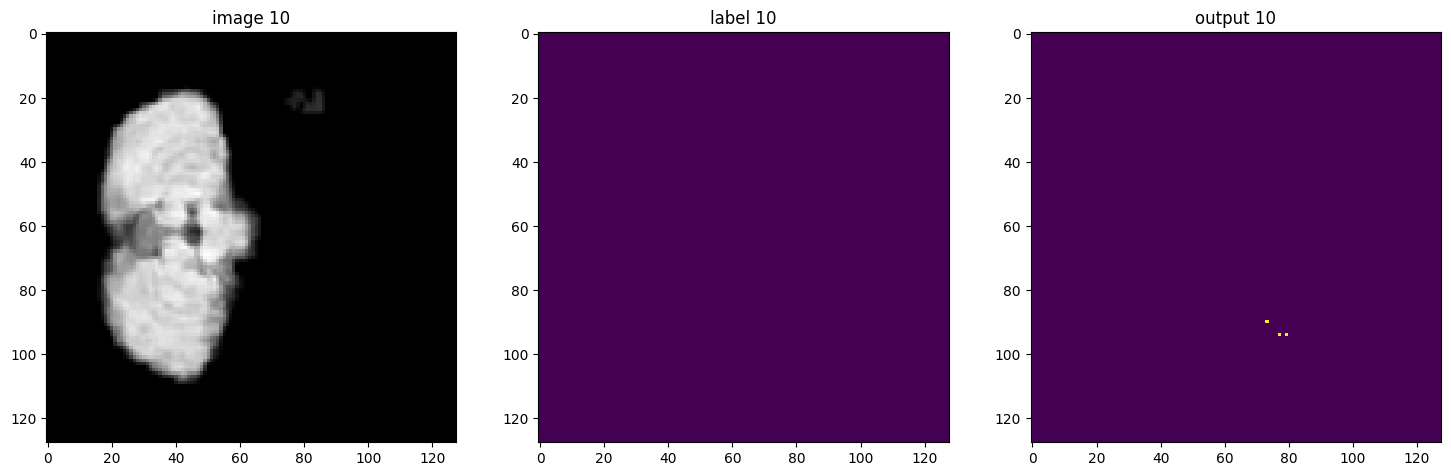

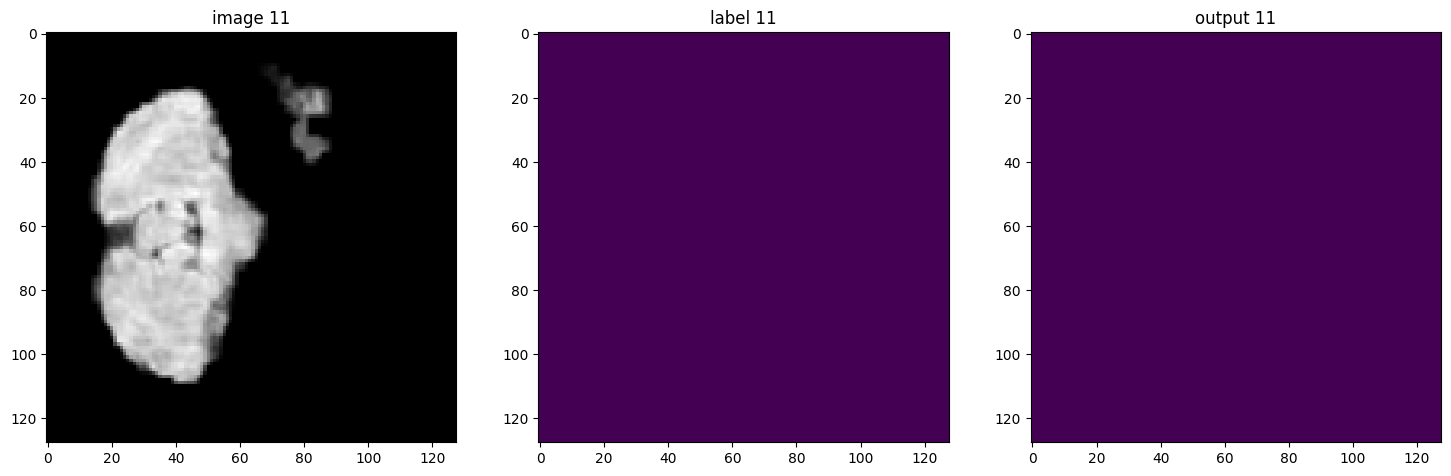

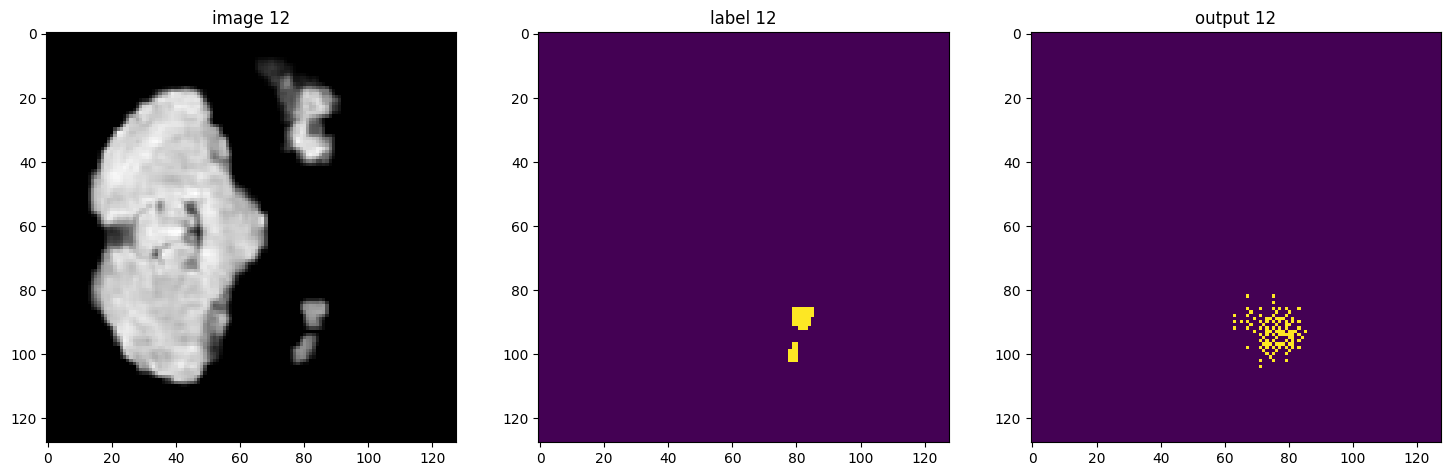

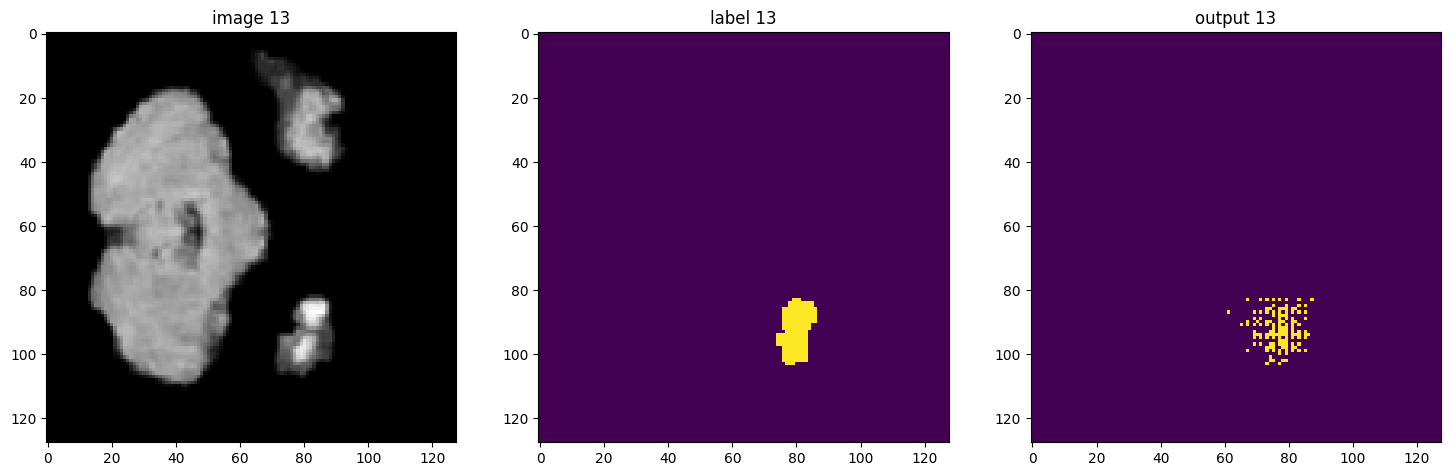

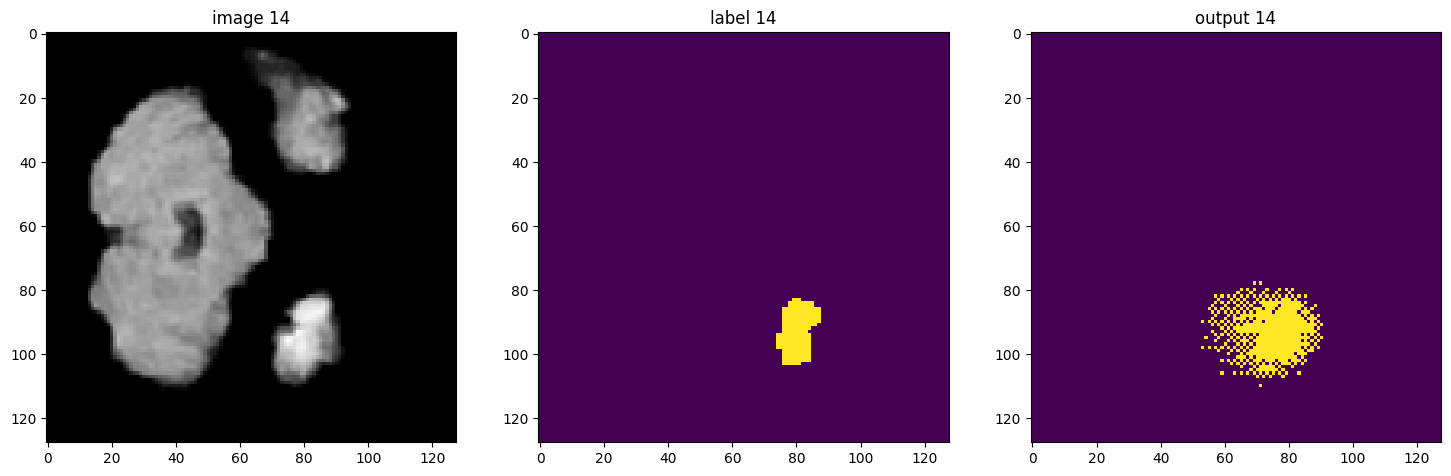

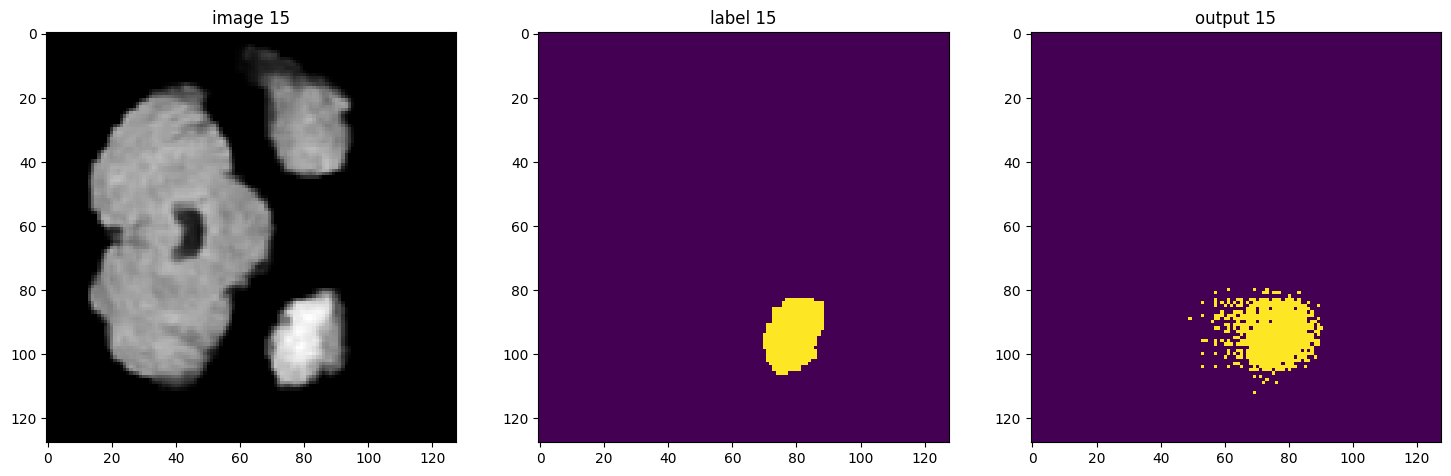

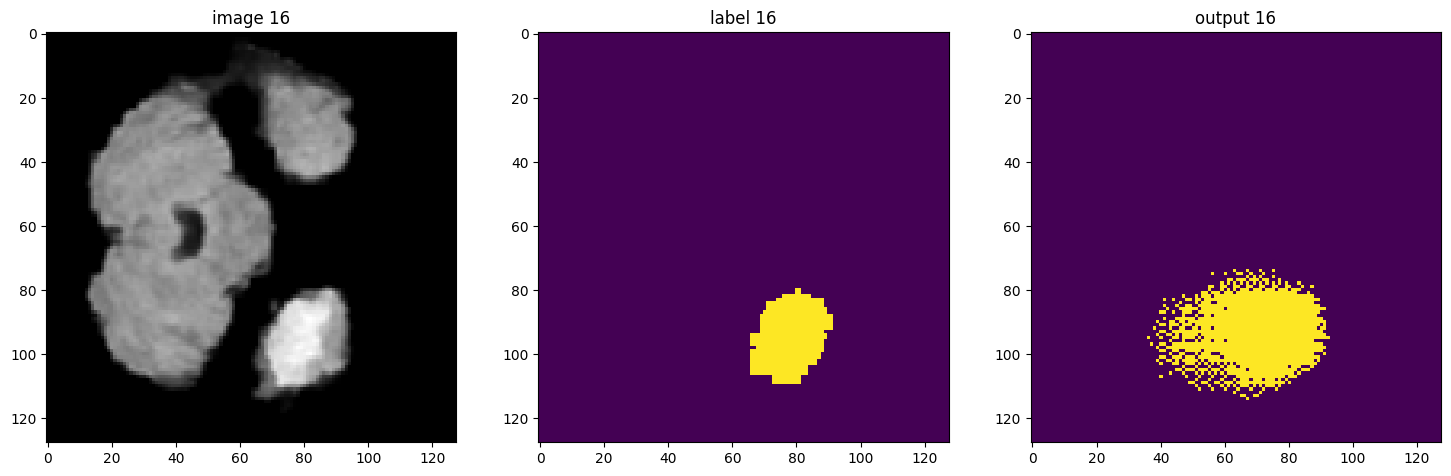

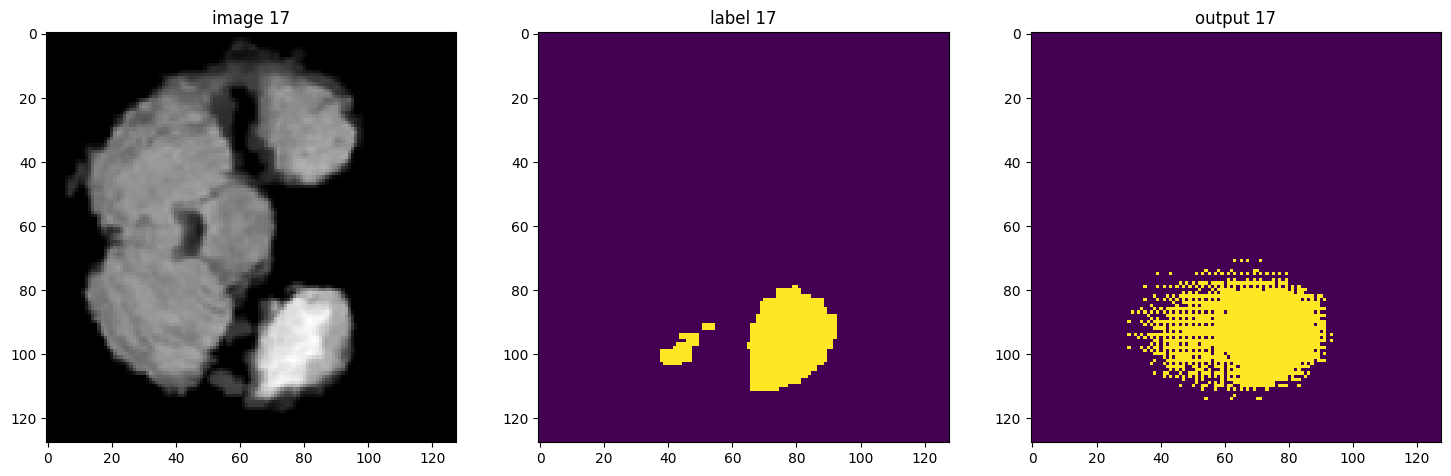

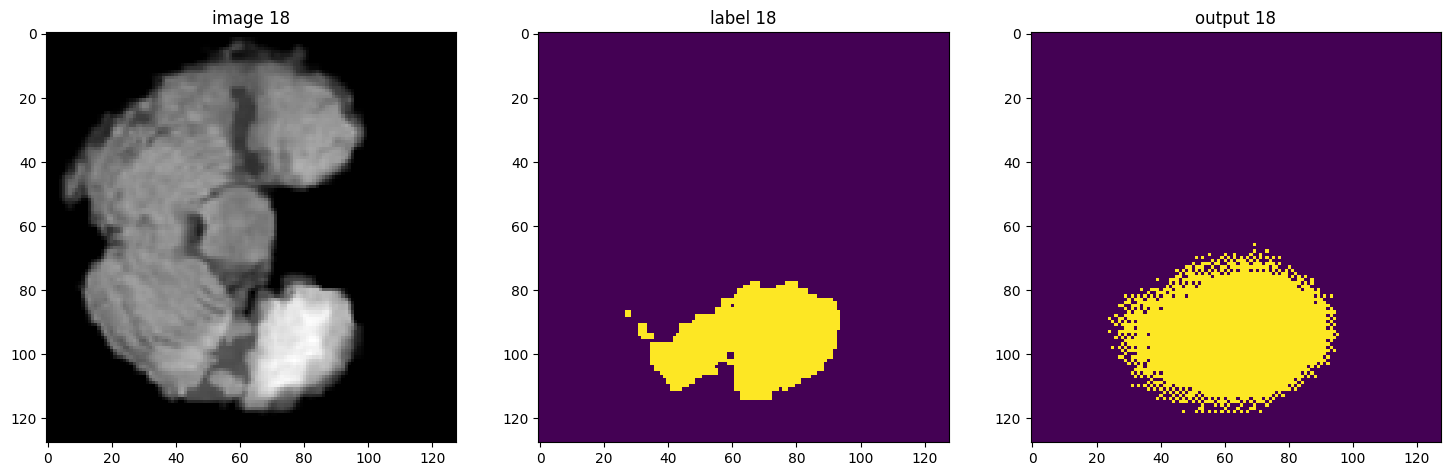

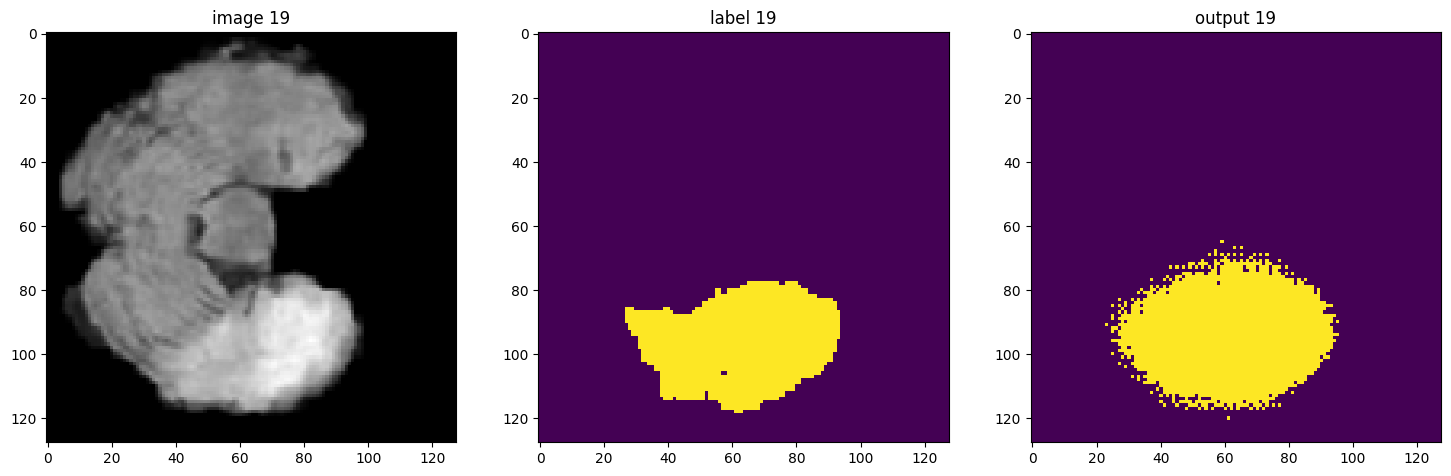

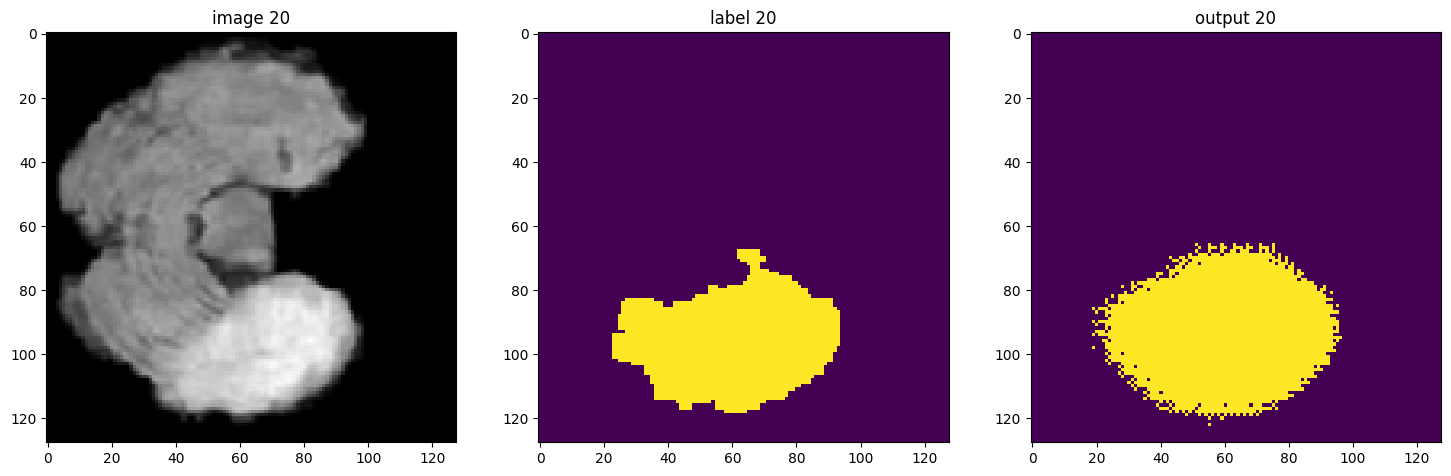

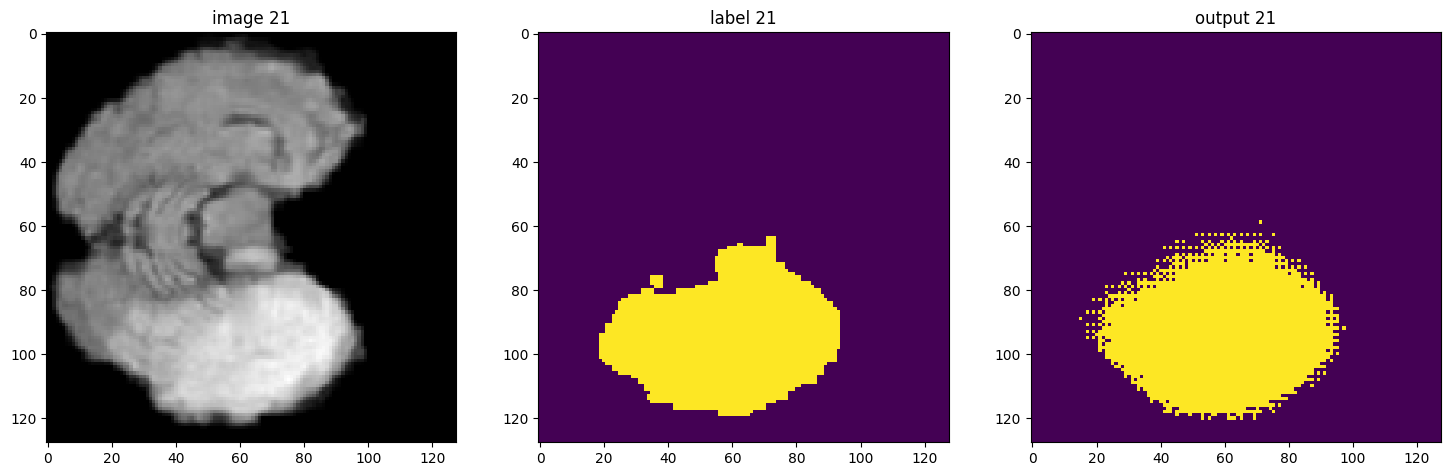

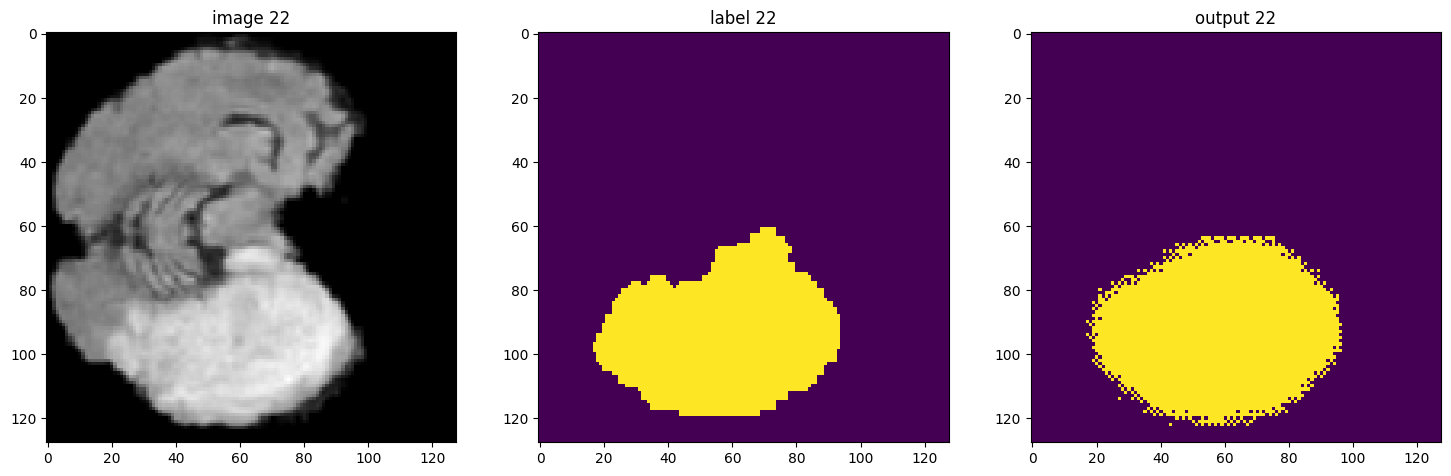

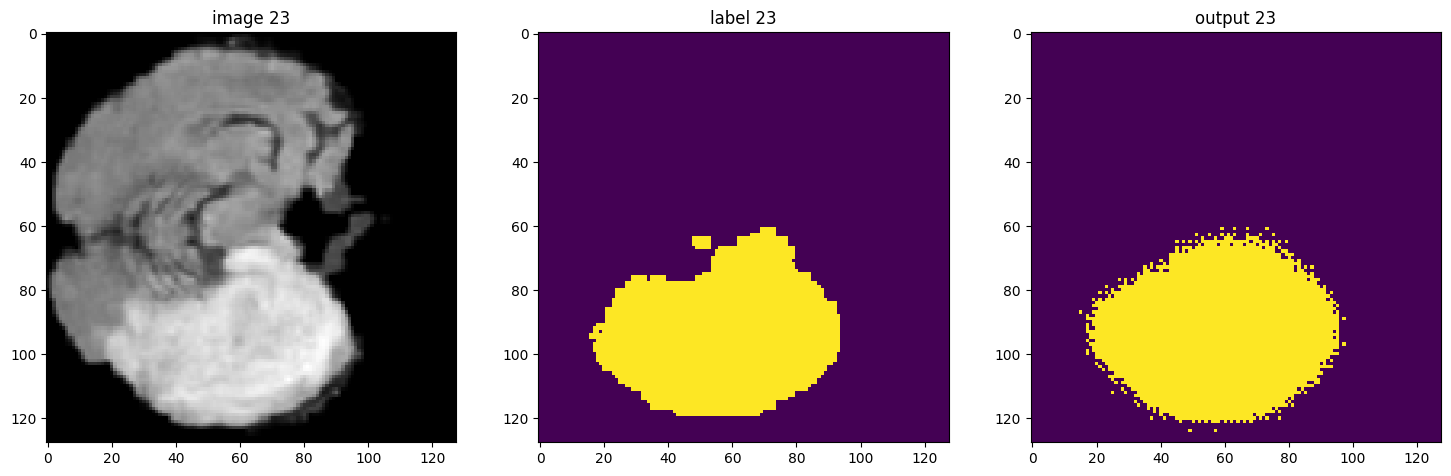

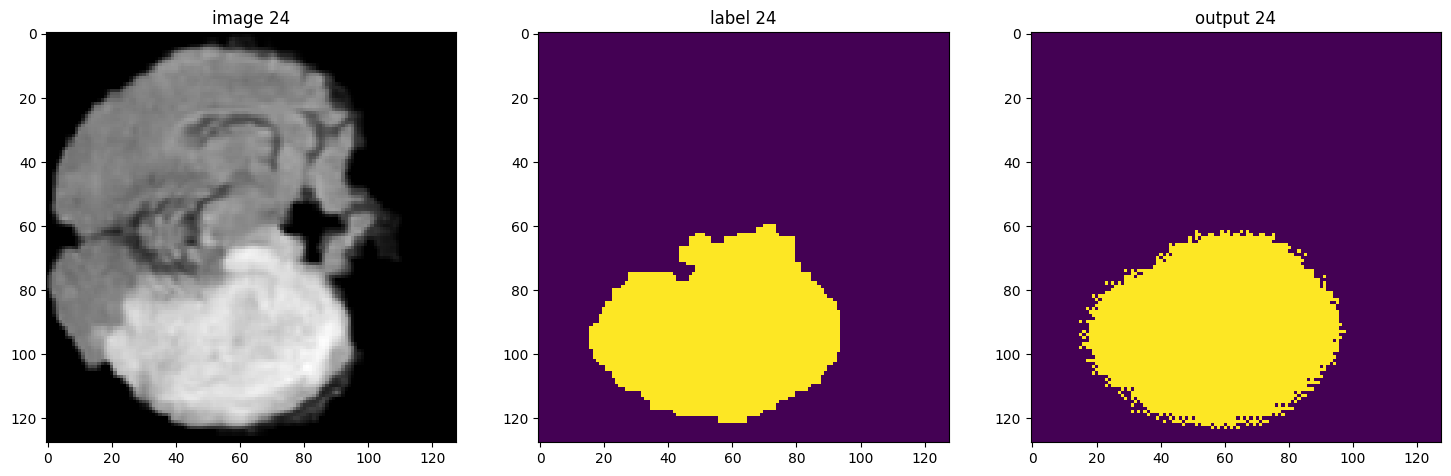

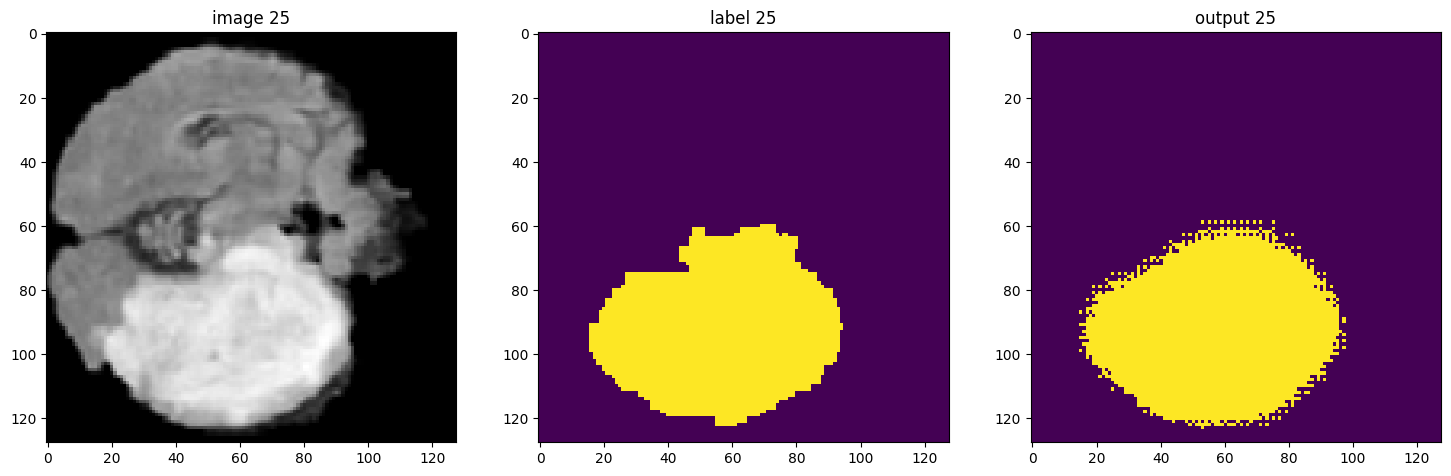

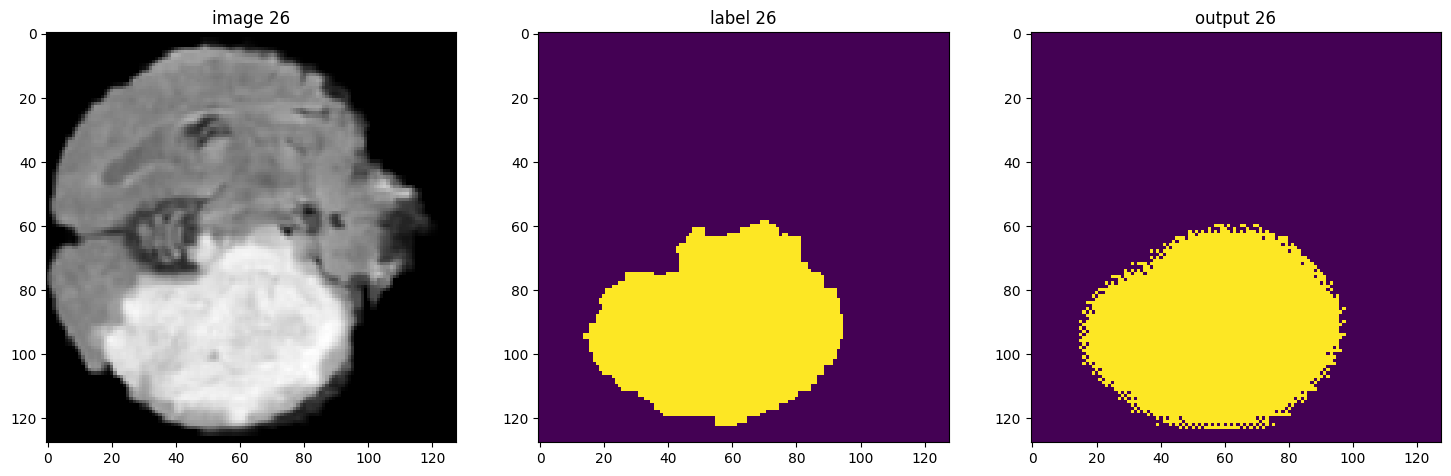

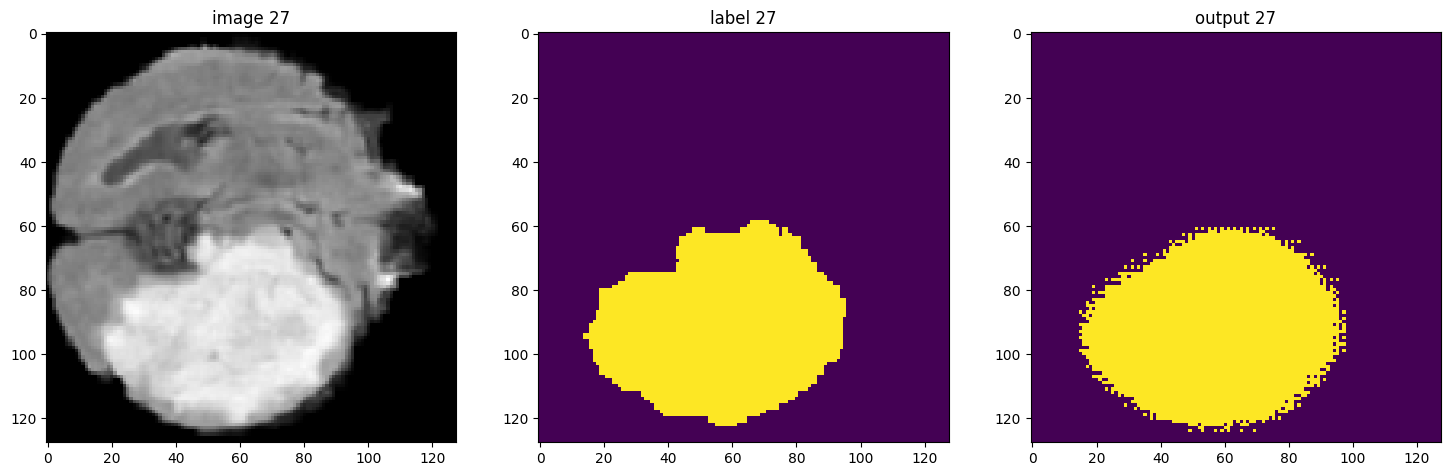

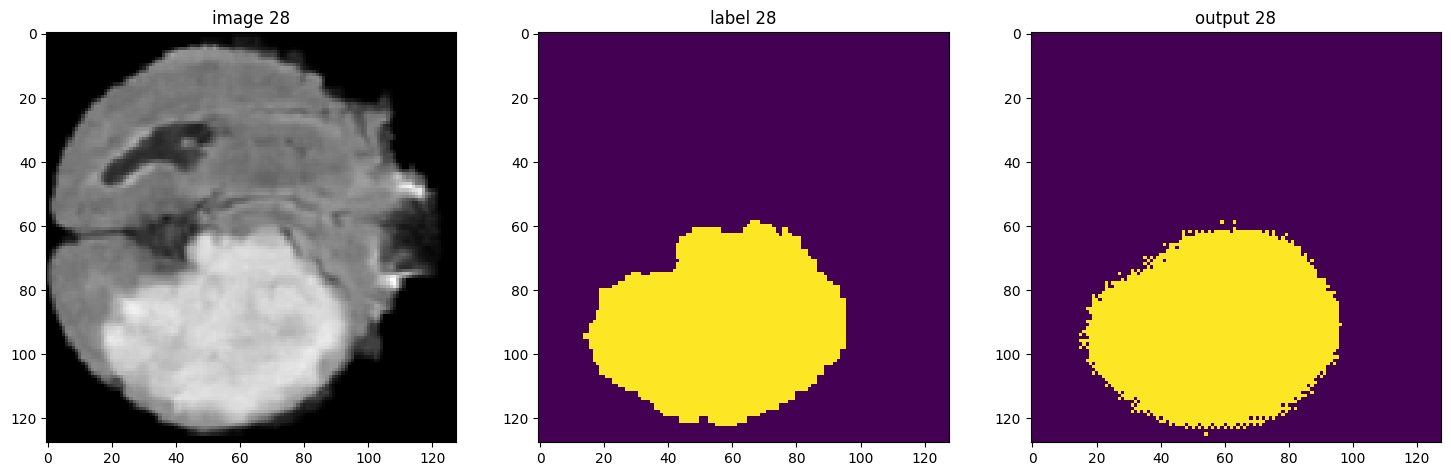

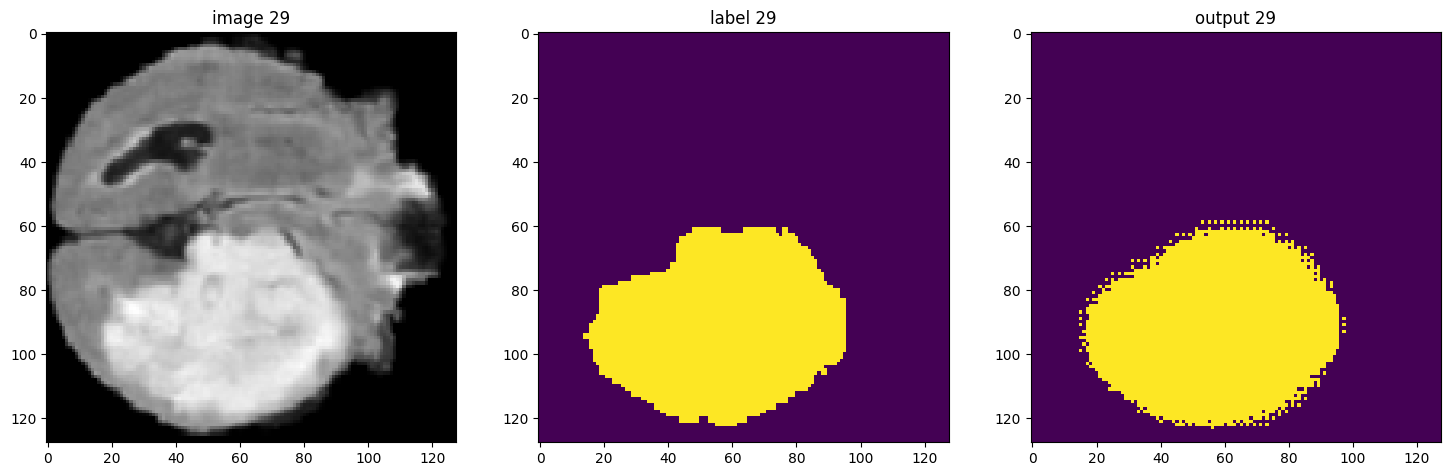

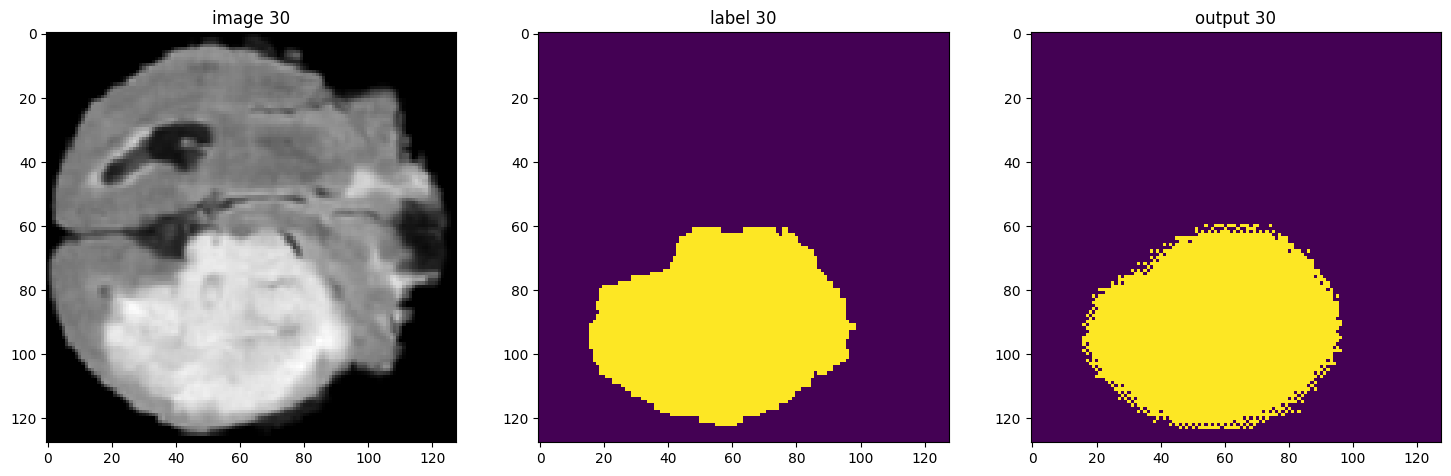

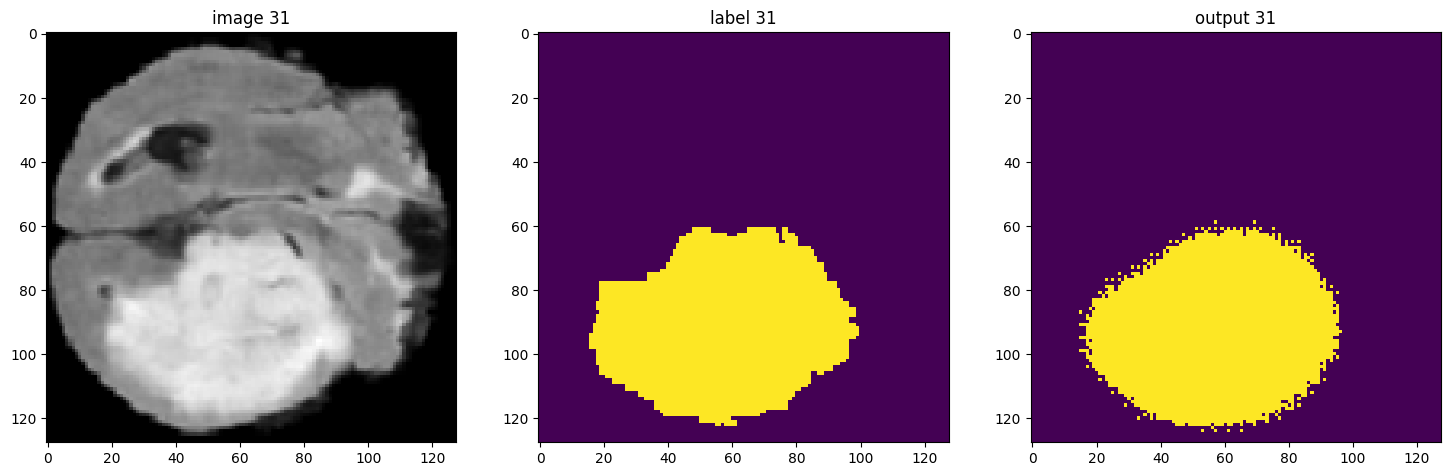

In [29]:
sw_batch_size = 4
roi_size = (128, 128, 64)
with torch.no_grad():
    test_patient = select_patient(2)
    t_volume = test_patient['image']
    #t_segmentation = test_patient['seg']
    
    test_outputs = sliding_window_inference(t_volume.to(device), roi_size, sw_batch_size, model)
    sigmoid_activation = Activations(sigmoid=True)
    test_outputs = sigmoid_activation(test_outputs)
    test_outputs = test_outputs > 0.90
        
    for i in range(32):
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(test_patient["image"][0, 0, :, :, i], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(test_patient["label"][0, 0, :, :, i] != 0)
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(test_outputs.detach().cpu()[0, 1, :, :, i])
        plt.show()